# 2a. Global climate and glacier projection analysis 
- creates `Fig. 2` (+ variants of it ...)
- creates `Extended Data Fig. 3` (with individual RGI region projections for all overshoot scenarios)
- creates `Supplementary Fig. 9` (with global precipitation evolution)

In [5]:
from oggm import utils
import json
import oggm
import sys
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
# get the correct colors for the different scenarios
from analysis_func import (color_scenario, color_scenario_poster, color_scenario_all_oversh, 
                           d_reg_num_name, label_scenario , scenario_ls)

palette = sns.color_palette(color_scenario.values())

# get the dataset where coordinates of glaciers are stored
frgi = utils.file_downloader('https://cluster.klima.uni-bremen.de/~oggm/rgi/rgi62_stats.h5')
odf = pd.read_hdf(frgi, index_col=0)
odf['coords'] = [(lon,lat) for lon,lat in zip(odf['CenLon'],odf['CenLat'])]

In [6]:
label_scenario = {'stab_T12': '1.2°C stabilization',
 'oversh_T30OS15': '3.0$\\rightarrow$1.5°C overshoot',
 'stab_T15': '1.5°C stabilization',
 'stab_T30': '3.0°C stabilization',
 'oversh_T20OS15': '2.0$\\rightarrow$1.5°C overshoot',
 'oversh_T25OS15': '2.5$\\rightarrow$1.5°C overshoot'}

In [7]:
plt.rcParams["pdf.use14corefonts"] = False  # don't convert text to path
plt.rcParams['pdf.fonttype']=42 # do nout line text?

In [8]:
pd_clim_all= pd.read_csv('../data/annual_glob_rgi_reg_basin_temp_precip_timeseries_oversh_stab.csv', 
                         index_col=['Unnamed: 0'])
bc = 'bc_1980_2019'
df_scenario = xr.open_dataset(f'../data/common_running_sum_all_rgi_reg_oversh_stab_2000_2500_{bc}.nc')
df_scenario['volume_asl'] = df_scenario.volume - df_scenario.volume_bsl 

In [10]:
df_scenario

<xarray.Dataset>
Dimensions:          (bias_correction: 1, rgi_reg: 19, scenario: 8, gcm: 1,
                      time: 501)
Coordinates:
  * time             (time) float64 2e+03 2.001e+03 ... 2.499e+03 2.5e+03
  * gcm              (gcm) <U10 'GFDL-ESM2M'
  * scenario         (scenario) <U14 'oversh_T20OS15' ... 'stab_T30'
  * bias_correction  (bias_correction) <U12 'bc_1980_2019'
  * rgi_reg          (rgi_reg) <U2 '01' '02' '03' '04' ... '16' '17' '18' '19'
Data variables:
    runoff           (bias_correction, rgi_reg, scenario, gcm, time) float32 ...
    melt_off_on      (bias_correction, rgi_reg, scenario, gcm, time) float32 ...
    volume           (bias_correction, rgi_reg, scenario, gcm, time) float32 ...
    area             (bias_correction, rgi_reg, scenario, gcm, time) float32 ...
    volume_bsl       (bias_correction, rgi_reg, scenario, gcm, time) float32 ...
    volume_asl       (bias_correction, rgi_reg, scenario, gcm, time) float32 ...
Attributes:
    info:               Glacier volume, area, and runoff projections from 200...
    aggregation_level:  aggregated per RGI6 region (rgi_reg) for the common r...
    version:            OGGM v1.6.1 with preprocessed gdirs 2023.3
    creation_date:      2024-11-19
    reference:          Schuster et al., in review

In [11]:
num_dict = {0:'a', 1:'b', 2:'c', 3:'d', 4: 'e',
            5:'f', 6:'g', 7:'h', 8:'i', 9:'j',
            10:'k', 11:'l', 12:'m'} 

#### also load SLE equivalent

In [12]:
# sea level makes only sense globally for this study
ds = df_scenario.sum(dim='rgi_reg')
# we are only interested in the volume above sea level estimate
ds['volume_asl'] = ds.volume - ds.volume_bsl 
# in 2020 we just have one estimate
assert (ds.sel(time=2020).volume_asl.std()/ds.sel(time=2020).volume_asl.mean()).round(4)<0.001
ds_2020_volume_asl = ds.sel(time=2020).volume_asl.mean().values
# test if volume above sea level completely melts 
vol_asl_diff_2020 = ds_2020_volume_asl #- ds_2500_volume_asl
# convert m3 into sea-level equivalent 
A_ocean = 3.625 * 10**8 * 1e6 #km2 -> 1e6
m_slr_all_2020_volume_lost = (vol_asl_diff_2020/A_ocean) *900/1028 # rhoice/rho_ocean
mm_slr_all_2020_volume_lost = m_slr_all_2020_volume_lost * 1000
### Farinotti et al 2019 states around 333mm in 2003, so around 319 in 2020 sounds reasonable... oK! 
# also note that this is the OGGM above sea-level estimates, thus can be different to the Farinotti et al. 2019 community estimate 
# (even if we would look at the same date, but here we also look at another date, i.e. 2020 and not the inventory year)
mm_slr_all_2020_volume_lost


319.7488829090331

In [13]:
# in 2500, volume asl depends on scenario
ds_volume_asl = ds.volume_asl
vol_asl_diff = ds_2020_volume_asl - ds_volume_asl
# convert m3 into sea-level equivalent 
m_slr = (vol_asl_diff/A_ocean) *900/1028 # rhoice/rho_ocean
mm_slr = m_slr * 1000
pd_mm_slr = mm_slr.to_dataframe('mm_sle').reset_index()


**get some numbers for the SLE estimates**

In [14]:
# this is what we chose --> with varying volume aobve sea-level ... 
mm_slr.sel(time=2500).to_dataframe()

time  volume_asl
bias_correction scenario       gcm                           
bc_1980_2019    oversh_T20OS15 GFDL-ESM2M  2500.0  118.601303
                oversh_T25OS15 GFDL-ESM2M  2500.0  137.720215
                oversh_T30OS15 GFDL-ESM2M  2500.0  143.679489
                stab_T12       GFDL-ESM2M  2500.0   89.735893
                stab_T15       GFDL-ESM2M  2500.0  109.320969
                stab_T20       GFDL-ESM2M  2500.0  142.002731
                stab_T25       GFDL-ESM2M  2500.0  170.192047
                stab_T30       GFDL-ESM2M  2500.0  188.963074

In [15]:
# maximum difference of overshoot vs stabilisation 1.5°C in terms of mm SLE 
((mm_slr.sel(scenario='oversh_T30OS15')- mm_slr.sel(scenario='stab_T15'))).max()

<xarray.DataArray 'volume_asl' ()>
array(50.04161072)

## Newest approach (four-row version)

In [16]:
stabs = ['stab_T12', 'stab_T15', 'stab_T30']
stabs_col = [color_scenario_poster['stab_T12'], color_scenario_poster['stab_T15'] ,
             color_scenario_poster['stab_T30']]


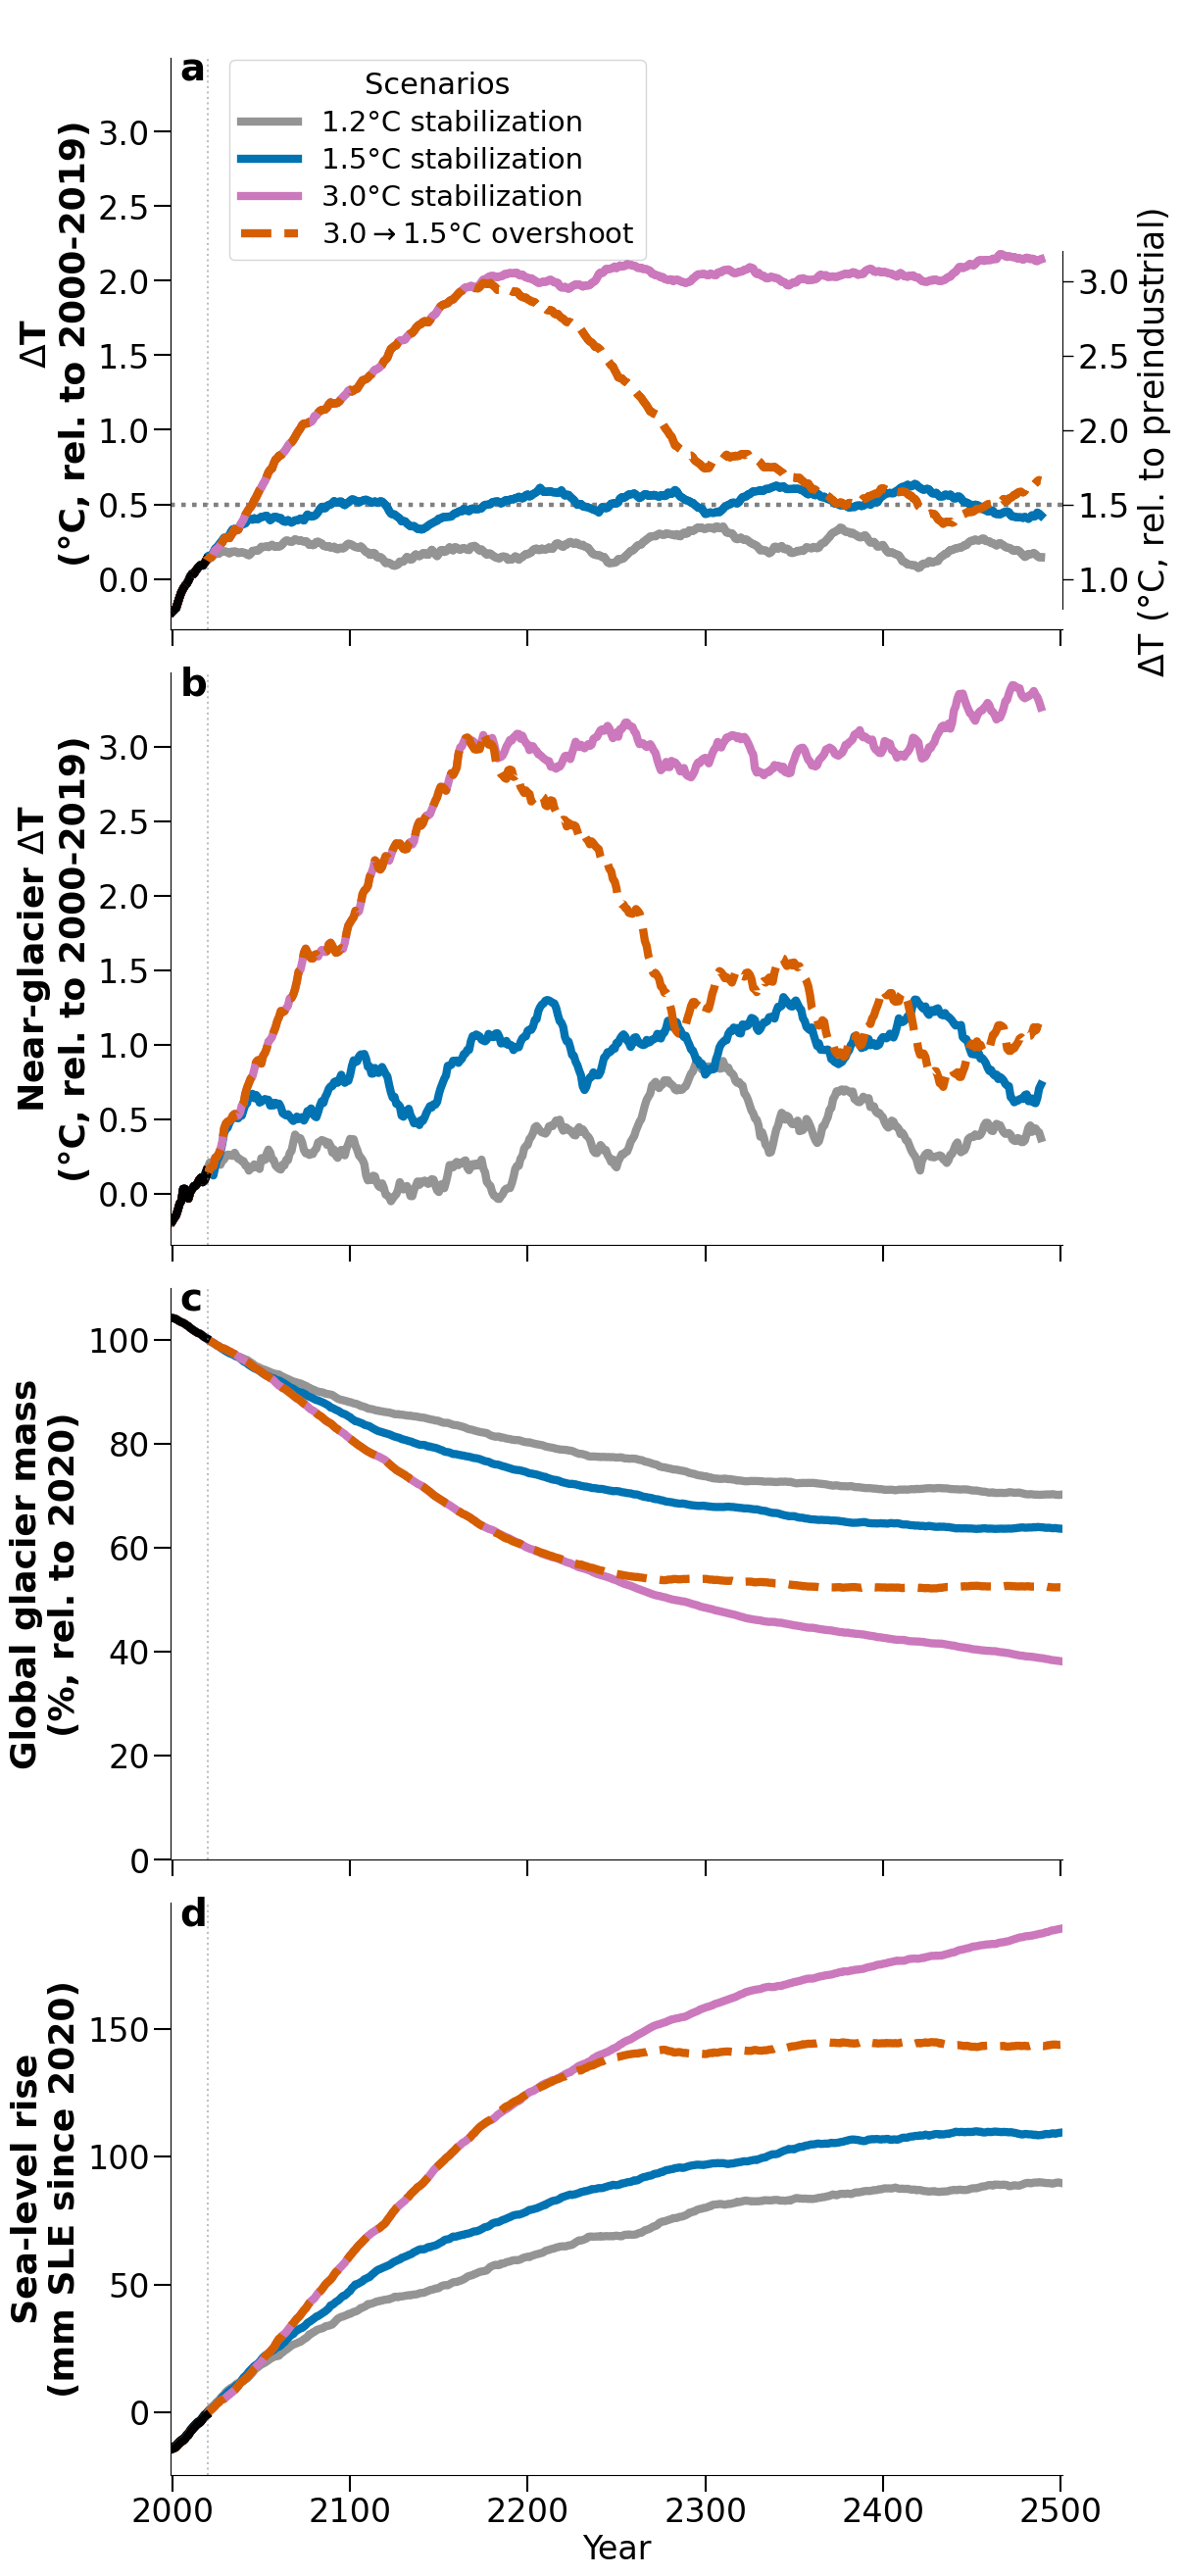

In [17]:
## 4-row version
plt.rc('font', size=24)
fs = 24 #5
shift = 1.2
shift_l = 0 #-0.4

alpha = 1
for a,c_scenarios in zip([#'_all', 
                        '_poster_iugg'],
                        #,
                        #'_all_overshoots'],
                       [#color_scenario.keys(),
                        color_scenario_poster
                       ]): #color_scenario_all_oversh]): 
    scenarios = c_scenarios.keys()
    for j,var in enumerate(['temp_21yr_avg',
                           ]):
        fig, axs = plt.subplots(4,1, figsize=(12.2,26), sharex=True) # 22, .... 6.2,5
        #####################
        ax = axs[0] #[0]
        ax_r = ax.twinx()
        for scenario in scenarios:
                        #'stab_T30']:

            pd_clim_scenario = pd_clim_all.loc[pd_clim_all.scenario==scenario]
            pd_clim_scenario_g = pd_clim_scenario.loc[pd_clim_scenario.region == 'global']
            pd_clim_scenario_g.index = pd_clim_scenario_g.year
            pd_clim_scenario_g_ref = pd_clim_scenario_g.loc[1986:2005]['temp'].mean()

            if var == 'temp_21yr_avg':
                var_g_to_ref = pd_clim_scenario_g[var]- pd_clim_scenario_g_ref + 0.69
                if 'oversh' in scenario:
                    ls = '--'
                elif 'stab' in scenario:
                    ls = '--'
                else:
                    ls = '--'
                ax_r.plot(np.arange(2000,2500,1),
                        var_g_to_ref.loc[2000:],
                        ls = scenario_ls[scenario],
                         lw=6, color = color_scenario[scenario], label=label_scenario[scenario], zorder=5)
                ax_r.plot(np.arange(2000,2020,1),
                        var_g_to_ref.loc[2000:2019],
                        ls = scenario_ls[scenario],
                         lw=6, color = 'black', 
                          zorder=5)
                ax_r.set_xlabel('Year')
                #ax_r.set_title(scenario)
                ax_r.axhline(1.5, color = 'grey', lw = 3, ls = ':', alpha = 0.8)
                ax_r.set_yticks(ticks=[1.0,1.5,2.0, 2.5, 3.0],
                           labels=[1.0,1.5,2.0, 2.5, 3.0])   
            else:
                ax_r.set_yticks([],[])
        ylim_ax = ax_r.get_ylim()
        ax_r.set_ylim([ylim_ax[0]+shift_l, ylim_ax[1]+shift])
        # we switch left and right axis .. 
        ax2 = ax ###

        for scenario in scenarios:
            pd_clim_scenario = pd_clim_all.loc[pd_clim_all.scenario==scenario]
            pd_clim_scenario_g = pd_clim_scenario.loc[pd_clim_scenario.region == 'global']
            pd_clim_scenario_g.index = pd_clim_scenario_g.year
            temp_ref_g, precip_ref_g = pd_clim_scenario_g.loc[2000:2019][['temp','precip']].mean()
            if var == 'temp_21yr_avg':
                var_g_to_ref = pd_clim_scenario_g[var] - temp_ref_g
            else:
                var_g_to_ref = 100*pd_clim_scenario_g[var]/precip_ref_g
            if 'oversh' in scenario:
                ls = '--'
            elif 'stab' in scenario:
                ls = '-.'
            else:
                ls = '-'
            ax2.plot(pd_clim_scenario_g.year.loc[2000:],
                     var_g_to_ref.loc[2000:], ls = scenario_ls[scenario], #ls,
                     lw=6,  #0.5,  # we actually do not want to see that one... <--- just put that to non-zero for tests ... 
                     color = color_scenario[scenario], label=label_scenario[scenario],
                    zorder=5)
            ax2.plot(pd_clim_scenario_g.year.loc[2000:2019],
                     var_g_to_ref.loc[2000:2019], ls = scenario_ls[scenario], #ls,
                     lw=6,  #0.5,  # we actually do not want to see that one... <--- just put that to non-zero for tests ... 
                     color = 'black', 
                    zorder=5)
            #ax.axhline(1.5, color = 'grey', lw = 3, ls = '--')
        ylim_ax2 = ax2.get_ylim()
        ax2.set_ylim([ylim_ax2[0]+shift_l, ylim_ax2[1]+shift])
        
        ax2.tick_params(axis='both', which='major', width=3, length=12) #width=1, length=10) #, grid_alpha =0.6)
        ax2.set_yticks(ticks=[0.0,0.5,1.0,1.5,2.0, 2.5, 3.0],
                           labels=[0.0,0.5,1.0,1.5,2.0, 2.5, 3.0], alpha=1, #0.6, 
                       fontsize=fs) #-1)
        handles, labels = ax.get_legend_handles_labels()
        if a=='':
            ncol=1
            leg = ax.legend(handles[:len(scenarios)], labels[:len(scenarios)], 
                            title='scenarios reaching +1.5°C\n(21-year average)', fontsize=22, ncol=ncol)
        else:
            ncol=2
            if a=='_all':
                fontsize=22
            else:
                fontsize=22
            leg = ax.legend(handles[:len(scenarios)], labels[:len(scenarios)],ncol=1,
                            fontsize=21,
                            title = 'Scenarios',
                            labelspacing=0.34,
                            #fontsize=20,
                            title_fontsize=22,
                            bbox_to_anchor=(0.05,1.02), 
                            loc='upper left', 
                           ) 
        if var != 'temp_21yr_avg':
            leg.remove()
        #ax.grid()
        ax.set_xlabel('')
        
        ax_r.set_ylabel(r'$\Delta$T'+r' (°C, rel. to preindustrial)                   ', fontsize=fs+1)

        ax2.set_ylabel(r'$\Delta$T'+'\n(°C, rel. to 2000-2019)', alpha=1, fontsize=fs+2, weight='bold')

        ax.set_title('')
        plt.tight_layout()
        plt.xticks(fontsize=28)

        ylim_l = ax2.get_ylim()
        ###########
        ax = axs[1]
        for scenario in scenarios:
            pd_clim_scenario = pd_clim_all.loc[pd_clim_all.scenario==scenario]
            pd_clim_scenario_g = pd_clim_scenario.loc[pd_clim_scenario.region == 'global_glacier']
            pd_clim_scenario_g.index = pd_clim_scenario_g.year
            temp_ref_g, precip_ref_g = pd_clim_scenario_g.loc[2000:2019][['temp','precip']].mean()
            var_g_to_ref = pd_clim_scenario_g[var] - temp_ref_g

            ax.plot(pd_clim_scenario_g.year,
                     var_g_to_ref,
                     alpha = 1,
                     ls = scenario_ls[scenario],
                     lw=6, color = color_scenario[scenario], label=label_scenario[scenario])
            ax.plot(pd_clim_scenario_g.year.loc[2000:2019],
                     var_g_to_ref.loc[2000:2019],
                     lw=6, color = 'black')
        ax.set_ylabel(r'Near-glacier $\Delta$T'+'\n(°C, rel. to 2000-2019)', alpha=1, fontsize=fs+2, weight='bold')
        ax.set_ylim([ylim_l[0], ylim_l[1]])
        ax.tick_params(axis='both', which='major', width=3, length=12) #width=1, length=10) #, grid_alpha =0.6)
        ax.set_yticks(ticks=[0.0,0.5,1.0,1.5,2.0, 2.5, 3.0],
                           labels=[0.0,0.5,1.0,1.5,2.0, 2.5, 3.0], alpha=1, #0.6, 
                       fontsize=fs) 
        #######################
        # volume plot
        #####
        ax = axs[2]
        color_scenarios = c_scenarios 
        for alpha in [0,1]: # 0
            if alpha == 0:
                lw_temp =3
            else:
                lw_temp = 1
            scenarios = color_scenarios.keys()
            paletti = list(color_scenarios.values())     
            pd_vol_scenario_rel = (100*df_scenario/df_scenario.sel(time=2020)).volume.to_dataframe('volume_rel_2020_%').reset_index()
            df_scenario_glob = df_scenario.sum(dim='rgi_reg')

            pd_vol_scenario_glob = (100*df_scenario_glob/df_scenario_glob.sel(time=2020)).volume.to_dataframe('volume_rel_2020_%').reset_index()

            ax.set_ylabel('Global glacier mass\n(%, rel. to 2020)', weight='bold',alpha = 1, fontsize=fs+2)
            # stabilisation scenarios with ls = '-'
            sns.lineplot(data=pd_vol_scenario_glob.loc[(pd_vol_scenario_glob.bias_correction==bc) & (pd_vol_scenario_glob.scenario != 'oversh_T30OS15')],
                         hue='scenario', x='time', y= 'volume_rel_2020_%', 
                         alpha = alpha,
                         palette=stabs_col,
                         hue_order=stabs,lw=6, legend=False,
                         ax = ax)
            # overshoot with '--'
            sns.lineplot(data=pd_vol_scenario_glob.loc[(pd_vol_scenario_glob.bias_correction==bc) & (pd_vol_scenario_glob.scenario == 'oversh_T30OS15')],
                         #hue='scenario',
                         x='time', y= 'volume_rel_2020_%', 
                         alpha = alpha,
                         color=color_scenario_poster['oversh_T30OS15'],
                         hue_order=['oversh_T30OS15'],lw=6, 
                         ls = '--',
                         legend=False,
                         ax = ax)
            ax.set_xlabel('',  #weight='bold','
                          fontsize= fs)
            ax.tick_params(axis='both', which='major', width=2, length=10)
            ax.set_ylim([0,110]) #ax.get_ylim()[1]])
            ax.set_yticks(ticks=np.arange(0,110,20), alpha=alpha)
            ax.grid(axis='x')
            ax.axhline(31, alpha=0)

            ### mm sle--> decided to not include ... 
            #ax2 = axs[2].secondary_yaxis(1., functions=(vol_rel_2020_to_mm_SLE, 
            #                         mm_SLE_to_vol_rel_2020))
            #ax2.set_ylabel('mm SLE (since 2020)',fontsize= fs)
            #ax2.invert_yaxis()
        
            
        sns.lineplot(data=pd_vol_scenario_glob.loc[(pd_vol_scenario_glob.bias_correction==bc)
                                                   & (pd_vol_scenario_glob.scenario != 'oversh_T30OS15') & (pd_vol_scenario_glob.time<2020)],
                     x='time', y= 'volume_rel_2020_%', 
                     color='black',
                     lw=6, legend=False,
                     ax = ax)
        
        num_text_x = 0.01
        num_text_y = 0.96
        for j,axi in enumerate(axs):
            axi.axvline(2020, color='grey', alpha=0.5,ls=':')
            axi.text(num_text_x, num_text_y,
                     num_dict[j], fontsize=28, transform=axi.transAxes, zorder=10, weight='bold')
            axi.set_xlim([1999,2501])
            axi.set_xlabel('')
            axi.tick_params(axis='both', which='major', width=1.5, length=12)
            sns.despine(ax=axi, top=True, right=True, left=False, bottom=False, offset=None, trim=False)
        
        # Remove the top spine
        sns.despine(ax=ax_r, top=True, right=False, left=False, bottom=False, offset=None, trim=False)
        ax_r.tick_params(axis='y', which='major', width=1, length=8)

        ax_r.spines['right'].set_bounds([0.8, 3.2])

        # Manually trim only the right spine
        #ax2.spines['right'].set_visible(True)
        #ax2.spines['right'].set_bounds(ax2.get_ylim())

        # Optional: to avoid trimming left and bottom spines, ensure they are not trimmed explicitly
        #ax2.spines['left'].set_visible(True)
        #ax2.spines['bottom'].set_visible(True)
        #ax2.spines['left'].set_position(('outward', 10)) 

        ax.set_xlabel('')


        ax =axs[3]
        for scenario in scenarios:
            pd_mm_slr_scenario = pd_mm_slr.loc[pd_mm_slr.scenario==scenario]
            pd_mm_slr_scenario.index = pd_mm_slr_scenario.time
            if 'oversh' in scenario:
                ls = '--'
            elif 'stab' in scenario:
                ls = '-.'
            else:
                ls = '-'
            ax.plot(pd_mm_slr_scenario.time,
                     pd_mm_slr_scenario['mm_sle'].values, ls = scenario_ls[scenario],
                     lw=6, color = color_scenario[scenario], label=label_scenario[scenario])
            ax.plot(pd_mm_slr_scenario.time.loc[2000:2019],
                     pd_mm_slr_scenario['mm_sle'].loc[2000:2019], 
                     lw=6, color = 'black')
        ax.set_xlabel('Year', fontsize= fs)
        ax.set_ylabel('Sea-level rise\n(mm SLE since 2020)', fontsize=fs+2, weight='bold')
        
        plt.tight_layout(pad=0.5)
        plt.savefig(f'../figures/fig_2.pdf', dpi=300)
        plt.savefig(f'../figures/fig_2.png', dpi=300)
        plt.savefig(f'../figures/fig_2.svg', dpi=300)


In [ ]:
# Lower dpi for figures that are only displayed in the notebooks, but not later saved elsewhere to reduce the total files size
plt.rcParams['figure.dpi'] = 72

#### 3-row version... 

In [ ]:
### 3-row version
plt.rc('font', size=24)
fs = 24 #5
shift = 1.2
shift_l = 0 #-0.4

alpha = 1
for a,c_scenarios in zip([#'_all', 
                        '_poster_iugg'],
                        #,
                        #'_all_overshoots'],
                       [#color_scenario.keys(),
                        color_scenario_poster
                       ]): #color_scenario_all_oversh]): 
    scenarios = c_scenarios.keys()
    for j,var in enumerate(['temp_21yr_avg',
                           ]):
        fig, axs = plt.subplots(3,1, figsize=(12.5,22), sharex=True) # 26.5
        #####################
        ax = axs[0] #[0]
        ax_r = ax.twinx()
        for scenario in scenarios:
                        #'stab_T30']:

            pd_clim_scenario = pd_clim_all.loc[pd_clim_all.scenario==scenario]
            pd_clim_scenario_g = pd_clim_scenario.loc[pd_clim_scenario.region == 'global']
            pd_clim_scenario_g.index = pd_clim_scenario_g.year
            pd_clim_scenario_g_ref = pd_clim_scenario_g.loc[1986:2005]['temp'].mean()

            if var == 'temp_21yr_avg':
                var_g_to_ref = pd_clim_scenario_g[var]- pd_clim_scenario_g_ref + 0.69
                if 'oversh' in scenario:
                    ls = '--'
                elif 'stab' in scenario:
                    ls = '--'
                else:
                    ls = '--'
                ax_r.plot(np.arange(2000,2500,1),
                        var_g_to_ref.loc[2000:],
                        ls = scenario_ls[scenario],
                         lw=6, color = color_scenario[scenario], label=label_scenario[scenario], zorder=5)
                ax_r.plot(np.arange(2000,2020,1),
                        var_g_to_ref.loc[2000:2019],
                        ls = scenario_ls[scenario],
                         lw=6, color = 'black', 
                          zorder=5)
                ax_r.set_xlabel('Year')
                #ax_r.set_title(scenario)
                ax_r.axhline(1.5, color = 'grey', lw = 3, ls = ':', alpha = 0.8)
                ax_r.set_yticks(ticks=[1.0,1.5,2.0, 2.5, 3.0],
                           labels=[1.0,1.5,2.0, 2.5, 3.0])   
            else:
                ax_r.set_yticks([],[])
        ylim_ax = ax_r.get_ylim()
        ax_r.set_ylim([ylim_ax[0]+shift_l, ylim_ax[1]+shift])
        # we switch left and right axis .. 
        ax2 = ax ###

        for scenario in scenarios:
            pd_clim_scenario = pd_clim_all.loc[pd_clim_all.scenario==scenario]
            pd_clim_scenario_g = pd_clim_scenario.loc[pd_clim_scenario.region == 'global']
            pd_clim_scenario_g.index = pd_clim_scenario_g.year
            temp_ref_g, precip_ref_g = pd_clim_scenario_g.loc[2000:2019][['temp','precip']].mean()
            if var == 'temp_21yr_avg':
                var_g_to_ref = pd_clim_scenario_g[var] - temp_ref_g
            else:
                var_g_to_ref = 100*pd_clim_scenario_g[var]/precip_ref_g
            if 'oversh' in scenario:
                ls = '--'
            elif 'stab' in scenario:
                ls = '-.'
            else:
                ls = '-'
            ax2.plot(pd_clim_scenario_g.year.loc[2000:],
                     var_g_to_ref.loc[2000:], ls = scenario_ls[scenario], #ls,
                     lw=6,  #0.5,  # we actually do not want to see that one... <--- just put that to non-zero for tests ... 
                     color = color_scenario[scenario], label=label_scenario[scenario],
                    zorder=5)
            ax2.plot(pd_clim_scenario_g.year.loc[2000:2019],
                     var_g_to_ref.loc[2000:2019], ls = scenario_ls[scenario], #ls,
                     lw=6,  #0.5,  # we actually do not want to see that one... <--- just put that to non-zero for tests ... 
                     color = 'black', 
                    zorder=5)
            #ax.axhline(1.5, color = 'grey', lw = 3, ls = '--')
        ylim_ax2 = ax2.get_ylim()
        ax2.set_ylim([ylim_ax2[0]+shift_l, ylim_ax2[1]+shift])
        
        ax2.tick_params(axis='both', which='major', width=3, length=12) #width=1, length=10) #, grid_alpha =0.6)
        ax2.set_yticks(ticks=[0.0,0.5,1.0,1.5,2.0, 2.5, 3.0],
                           labels=[0.0,0.5,1.0,1.5,2.0, 2.5, 3.0], alpha=1, #0.6, 
                       fontsize=fs) #-1)
        handles, labels = ax.get_legend_handles_labels()
        if a=='':
            ncol=1
            leg = ax.legend(handles[:len(scenarios)], labels[:len(scenarios)], 
                            title='scenarios reaching +1.5°C\n(21-year average)', fontsize=22, ncol=ncol)
        else:
            ncol=2
            if a=='_all':
                fontsize=22
            else:
                fontsize=22
            leg = ax.legend(handles[:len(scenarios)], labels[:len(scenarios)],ncol=1,
                            fontsize=21,
                            title = 'Scenarios',
                            #fontsize=20,
                            title_fontsize=22,
                            bbox_to_anchor=(0.05,1.02), 
                            loc='upper left', 
                           ) 
        if var != 'temp_21yr_avg':
            leg.remove()
        #ax.grid()
        ax.set_xlabel('')
        
        ax_r.set_ylabel(r'$\Delta$T'+r' (°C, rel. to preindustrial)                   ', fontsize=fs+1)

        ax2.set_ylabel(r'$\Delta$T'+'\n(°C, rel. to 2000-2019)', alpha=1, fontsize=fs+2, weight='bold')

        ax.set_title('')
        plt.tight_layout()
        plt.xticks(fontsize=28)

        ylim_l = ax2.get_ylim()
        ###########
        ax = axs[1]
        for scenario in scenarios:
            pd_clim_scenario = pd_clim_all.loc[pd_clim_all.scenario==scenario]
            pd_clim_scenario_g = pd_clim_scenario.loc[pd_clim_scenario.region == 'global_glacier']
            pd_clim_scenario_g.index = pd_clim_scenario_g.year
            temp_ref_g, precip_ref_g = pd_clim_scenario_g.loc[2000:2019][['temp','precip']].mean()
            var_g_to_ref = pd_clim_scenario_g[var] - temp_ref_g

            ax.plot(pd_clim_scenario_g.year,
                     var_g_to_ref,
                     alpha = 1,
                     ls = scenario_ls[scenario],
                     lw=6, color = color_scenario[scenario], label=label_scenario[scenario])
            ax.plot(pd_clim_scenario_g.year.loc[2000:2019],
                     var_g_to_ref.loc[2000:2019],
                     lw=6, color = 'black')
        ax.set_ylabel(r'Near-glacier $\Delta$T'+'\n(°C, rel. to 2000-2019)', alpha=1, fontsize=fs+2, weight='bold')
        ax.set_ylim([ylim_l[0], ylim_l[1]])
        ax.tick_params(axis='both', which='major', width=3, length=12) #width=1, length=10) #, grid_alpha =0.6)
        ax.set_yticks(ticks=[0.0,0.5,1.0,1.5,2.0, 2.5, 3.0],
                           labels=[0.0,0.5,1.0,1.5,2.0, 2.5, 3.0], alpha=1, #0.6, 
                       fontsize=fs) 
        #######################
        # volume plot
        #####
        ax = axs[2]
        color_scenarios = c_scenarios 
        for alpha in [0,1]: # 0
            if alpha == 0:
                lw_temp =3
            else:
                lw_temp = 1
            scenarios = color_scenarios.keys()
            paletti = list(color_scenarios.values())     
            pd_vol_scenario_rel = (100*df_scenario/df_scenario.sel(time=2020)).volume.to_dataframe('volume_rel_2020_%').reset_index()
            df_scenario_glob = df_scenario.sum(dim='rgi_reg')

            pd_vol_scenario_glob = (100*df_scenario_glob/df_scenario_glob.sel(time=2020)).volume.to_dataframe('volume_rel_2020_%').reset_index()

            ax.set_ylabel('Global glacier mass\n(%, rel. to 2020)', weight='bold',alpha = 1, fontsize=fs+2)
            # stabilisation scenarios with ls = '-'
            sns.lineplot(data=pd_vol_scenario_glob.loc[(pd_vol_scenario_glob.bias_correction==bc) & (pd_vol_scenario_glob.scenario != 'oversh_T30OS15')],
                         hue='scenario', x='time', y= 'volume_rel_2020_%', 
                         alpha = alpha,
                         palette=stabs_col,
                         hue_order=stabs,lw=6, legend=False,
                         ax = ax)
            # overshoot with '--'
            sns.lineplot(data=pd_vol_scenario_glob.loc[(pd_vol_scenario_glob.bias_correction==bc) & (pd_vol_scenario_glob.scenario == 'oversh_T30OS15')],
                         #hue='scenario',
                         x='time', y= 'volume_rel_2020_%', 
                         alpha = alpha,
                         color=color_scenario_poster['oversh_T30OS15'],
                         hue_order=['oversh_T30OS15'],lw=6, 
                         ls = '--',
                         legend=False,
                         ax = ax)
            ax.set_xlabel('Year',  #weight='bold','
                          fontsize= fs)
            ax.tick_params(axis='both', which='major', width=2, length=10)
            ax.set_ylim([0,110]) #ax.get_ylim()[1]])
            ax.set_yticks(ticks=np.arange(0,110,20), alpha=alpha)
            ax.grid(axis='x')
            ax.axhline(31, alpha=0)

            ### mm sle--> decided to not include ... 
            #ax2 = axs[2].secondary_yaxis(1., functions=(vol_rel_2020_to_mm_SLE, 
            #                         mm_SLE_to_vol_rel_2020))
            #ax2.set_ylabel('mm SLE (since 2020)',fontsize= fs)
            #ax2.invert_yaxis()
        
            
        sns.lineplot(data=pd_vol_scenario_glob.loc[(pd_vol_scenario_glob.bias_correction==bc)
                                                   & (pd_vol_scenario_glob.scenario != 'oversh_T30OS15') & (pd_vol_scenario_glob.time<2020)],
                     x='time', y= 'volume_rel_2020_%', 
                     color='black',
                     lw=6, legend=False,
                     ax = ax)
        
        num_text_x = 0.01
        num_text_y = 0.96
        for j,axi in enumerate(axs):
            axi.axvline(2020, color='grey', alpha=0.5,ls=':')
            axi.text(num_text_x, num_text_y,
                     num_dict[j], fontsize=28, transform=axi.transAxes, zorder=10, weight='bold')
            axi.set_xlim([1999,2501])
            axi.set_xlabel('')
            axi.tick_params(axis='both', which='major', width=1.5, length=12)
            sns.despine(ax=axi, top=True, right=True, left=False, bottom=False, offset=None, trim=False)
        
        # Remove the top spine
        sns.despine(ax=ax_r, top=True, right=False, left=False, bottom=False, offset=None, trim=False)
        ax_r.tick_params(axis='y', which='major', width=1, length=8)

        ax_r.spines['right'].set_bounds([0.8, 3.2])

        # Manually trim only the right spine
        #ax2.spines['right'].set_visible(True)
        #ax2.spines['right'].set_bounds(ax2.get_ylim())

        # Optional: to avoid trimming left and bottom spines, ensure they are not trimmed explicitly
        #ax2.spines['left'].set_visible(True)
        #ax2.spines['bottom'].set_visible(True)
        #ax2.spines['left'].set_position(('outward', 10)) 

        ax.set_xlabel('Year')

        plt.tight_layout()
        plt.savefig(f'../figures/fig_2_temp_vol_glob{a}_{alpha}_one_column_v_3_rows.pdf', dpi=300)
        plt.savefig(f'../figures/fig_2_temp_vol_glob{a}_{alpha}_one_column_v_3_rows.png', dpi=300)

In [9]:
ax.get_ylim()

(0.0, 120.0)

**Some stats for the text**

In [7]:
# in 2100 ... 
pd_vol_scenario_glob_2100 = pd_vol_scenario_glob.loc[pd_vol_scenario_glob.time==2100]
pd_vol_scenario_glob_2100

bias_correction        scenario         gcm    time  volume_rel_2020_%
100     bc_1980_2019  oversh_T20OS15  GFDL-ESM2M  2100.0          83.701508
601     bc_1980_2019  oversh_T25OS15  GFDL-ESM2M  2100.0          80.866661
1102    bc_1980_2019  oversh_T30OS15  GFDL-ESM2M  2100.0          80.931824
1603    bc_1980_2019        stab_T12  GFDL-ESM2M  2100.0          88.007278
2104    bc_1980_2019        stab_T15  GFDL-ESM2M  2100.0          85.112137
2605    bc_1980_2019        stab_T20  GFDL-ESM2M  2100.0          83.710197
3106    bc_1980_2019        stab_T25  GFDL-ESM2M  2100.0          80.868248
3607    bc_1980_2019        stab_T30  GFDL-ESM2M  2100.0          80.935158

In [8]:
# maximum volume difference
years = np.sort(np.array(list(set(pd_vol_scenario_glob.time.values))).astype(int))
pd_diff = pd.DataFrame(index = years)
for y in years:
    sel = pd_vol_scenario_glob.loc[pd_vol_scenario_glob.time==y]
    diff = sel.loc[sel.scenario == 'stab_T15']['volume_rel_2020_%'].values - sel.loc[sel.scenario == 'oversh_T30OS15']['volume_rel_2020_%'].values
    pd_diff.loc[y,'diff'] = diff
pd_diff.max(), pd_diff.idxmax()

(diff    15.957542
 dtype: float32,
 diff    2252
 dtype: int64)

In [9]:
pd_diff.loc[2100]

diff    4.180313
Name: 2100, dtype: float32

In [10]:
pd_diff.loc[2300]

diff    14.013824
Name: 2300, dtype: float32

In [11]:
# in 2500 ... 
pd_vol_scenario_glob_2500 = pd_vol_scenario_glob.loc[pd_vol_scenario_glob.time==2500]
pd_vol_scenario_glob_2500

bias_correction        scenario         gcm    time  volume_rel_2020_%
500     bc_1980_2019  oversh_T20OS15  GFDL-ESM2M  2500.0          60.637119
1001    bc_1980_2019  oversh_T25OS15  GFDL-ESM2M  2500.0          54.414013
1502    bc_1980_2019  oversh_T30OS15  GFDL-ESM2M  2500.0          52.390579
2003    bc_1980_2019        stab_T12  GFDL-ESM2M  2500.0          70.190300
2504    bc_1980_2019        stab_T15  GFDL-ESM2M  2500.0          63.668503
3005    bc_1980_2019        stab_T20  GFDL-ESM2M  2500.0          53.368359
3506    bc_1980_2019        stab_T25  GFDL-ESM2M  2500.0          44.535721
4007    bc_1980_2019        stab_T30  GFDL-ESM2M  2500.0          38.193905

In [12]:
pd_vol_scenario_glob_2500.loc[pd_vol_scenario_glob_2500.scenario =='stab_T15']['volume_rel_2020_%'].values - pd_vol_scenario_glob_2500.loc[pd_vol_scenario_glob_2500.scenario =='oversh_T30OS15']['volume_rel_2020_%'].values

array([11.277924], dtype=float32)

- the discrepancies between the Overshoot peaking at 3°C and the Stabilisation 1.5°C in the year 2500 are 11.3%

**Some stats to compare the different magnitudes of overshoot**

In [13]:
pd_vol_scenario_rel = (100*df_scenario/df_scenario.sel(time=2020)).volume.to_dataframe('volume_rel_2020_%').reset_index()
df_scenario_glob = df_scenario.sum(dim='rgi_reg')
pd_vol_scenario_glob = (100*df_scenario_glob/df_scenario_glob.sel(time=2020)).volume.to_dataframe('volume_rel_2020_%').reset_index()

In [14]:
for scenario in ['oversh_T20OS15', 'oversh_T25OS15', 'oversh_T30OS15']:
    _t_15 = pd_vol_scenario_glob.loc[(pd_vol_scenario_glob.time==2499) & (pd_vol_scenario_glob.scenario == 'stab_T15')]
    _t = pd_vol_scenario_glob.loc[(pd_vol_scenario_glob.time==2499) & (pd_vol_scenario_glob.scenario == scenario)]
    print(scenario, _t['volume_rel_2020_%'].values, _t_15['volume_rel_2020_%'].values - _t['volume_rel_2020_%'].values)
#- pd_vol_scenario_glob.scenario == 'stab_T15'

oversh_T20OS15 [60.645813] [3.0474396]
oversh_T25OS15 [54.403374] [9.289879]
oversh_T30OS15 [52.400192] [11.29306]


**Some stats to compare the different regional differences**

In [15]:
for rgi_reg in df_scenario.rgi_reg.values:
    df_scenario_reg = df_scenario.sel(rgi_reg=rgi_reg)
    pd_vol_scenario_reg = (100*df_scenario_reg/df_scenario_reg.sel(time=2020)).volume.to_dataframe('volume_rel_2020_%').reset_index()
    print(rgi_reg)
    for scenario in ['oversh_T20OS15', 'oversh_T25OS15', 'oversh_T30OS15']:
        _t_15 = pd_vol_scenario_reg.loc[(pd_vol_scenario_reg.time==2499) & (pd_vol_scenario_reg.scenario == 'stab_T15')]
        _t = pd_vol_scenario_reg.loc[(pd_vol_scenario_reg.time==2499) & (pd_vol_scenario_reg.scenario == scenario)]
        print(scenario, _t['volume_rel_2020_%'].values, _t_15['volume_rel_2020_%'].values - _t['volume_rel_2020_%'].values)

01
oversh_T20OS15 [59.314217] [6.01947]
oversh_T25OS15 [54.65902] [10.674667]
oversh_T30OS15 [57.776287] [7.5573997]
02
oversh_T20OS15 [20.441612] [1.6686249]
oversh_T25OS15 [14.973087] [7.13715]
oversh_T30OS15 [15.90497] [6.205267]
03
oversh_T20OS15 [78.98327] [0.96115875]
oversh_T25OS15 [75.09878] [4.8456497]
oversh_T30OS15 [73.163246] [6.7811813]
04
oversh_T20OS15 [20.506668] [-0.84054947]
oversh_T25OS15 [17.621304] [2.044815]
oversh_T30OS15 [17.263159] [2.4029598]
05
oversh_T20OS15 [40.836555] [2.0143738]
oversh_T25OS15 [36.251236] [6.5996933]
oversh_T30OS15 [35.05795] [7.79298]
06
oversh_T20OS15 [42.82344] [-2.8556747]
oversh_T25OS15 [34.422977] [5.5447884]
oversh_T30OS15 [37.87255] [2.0952148]
07
oversh_T20OS15 [77.966] [3.1585999]
oversh_T25OS15 [65.87824] [15.246361]
oversh_T30OS15 [63.557964] [17.566639]
08
oversh_T20OS15 [5.761099] [-0.30617857]
oversh_T25OS15 [3.1790607] [2.2758596]
oversh_T30OS15 [4.568096] [0.88682413]
09
oversh_T20OS15 [70.55844] [6.8518906]
oversh_T25OS1

## Suppl. figures

### **RGI region plot**

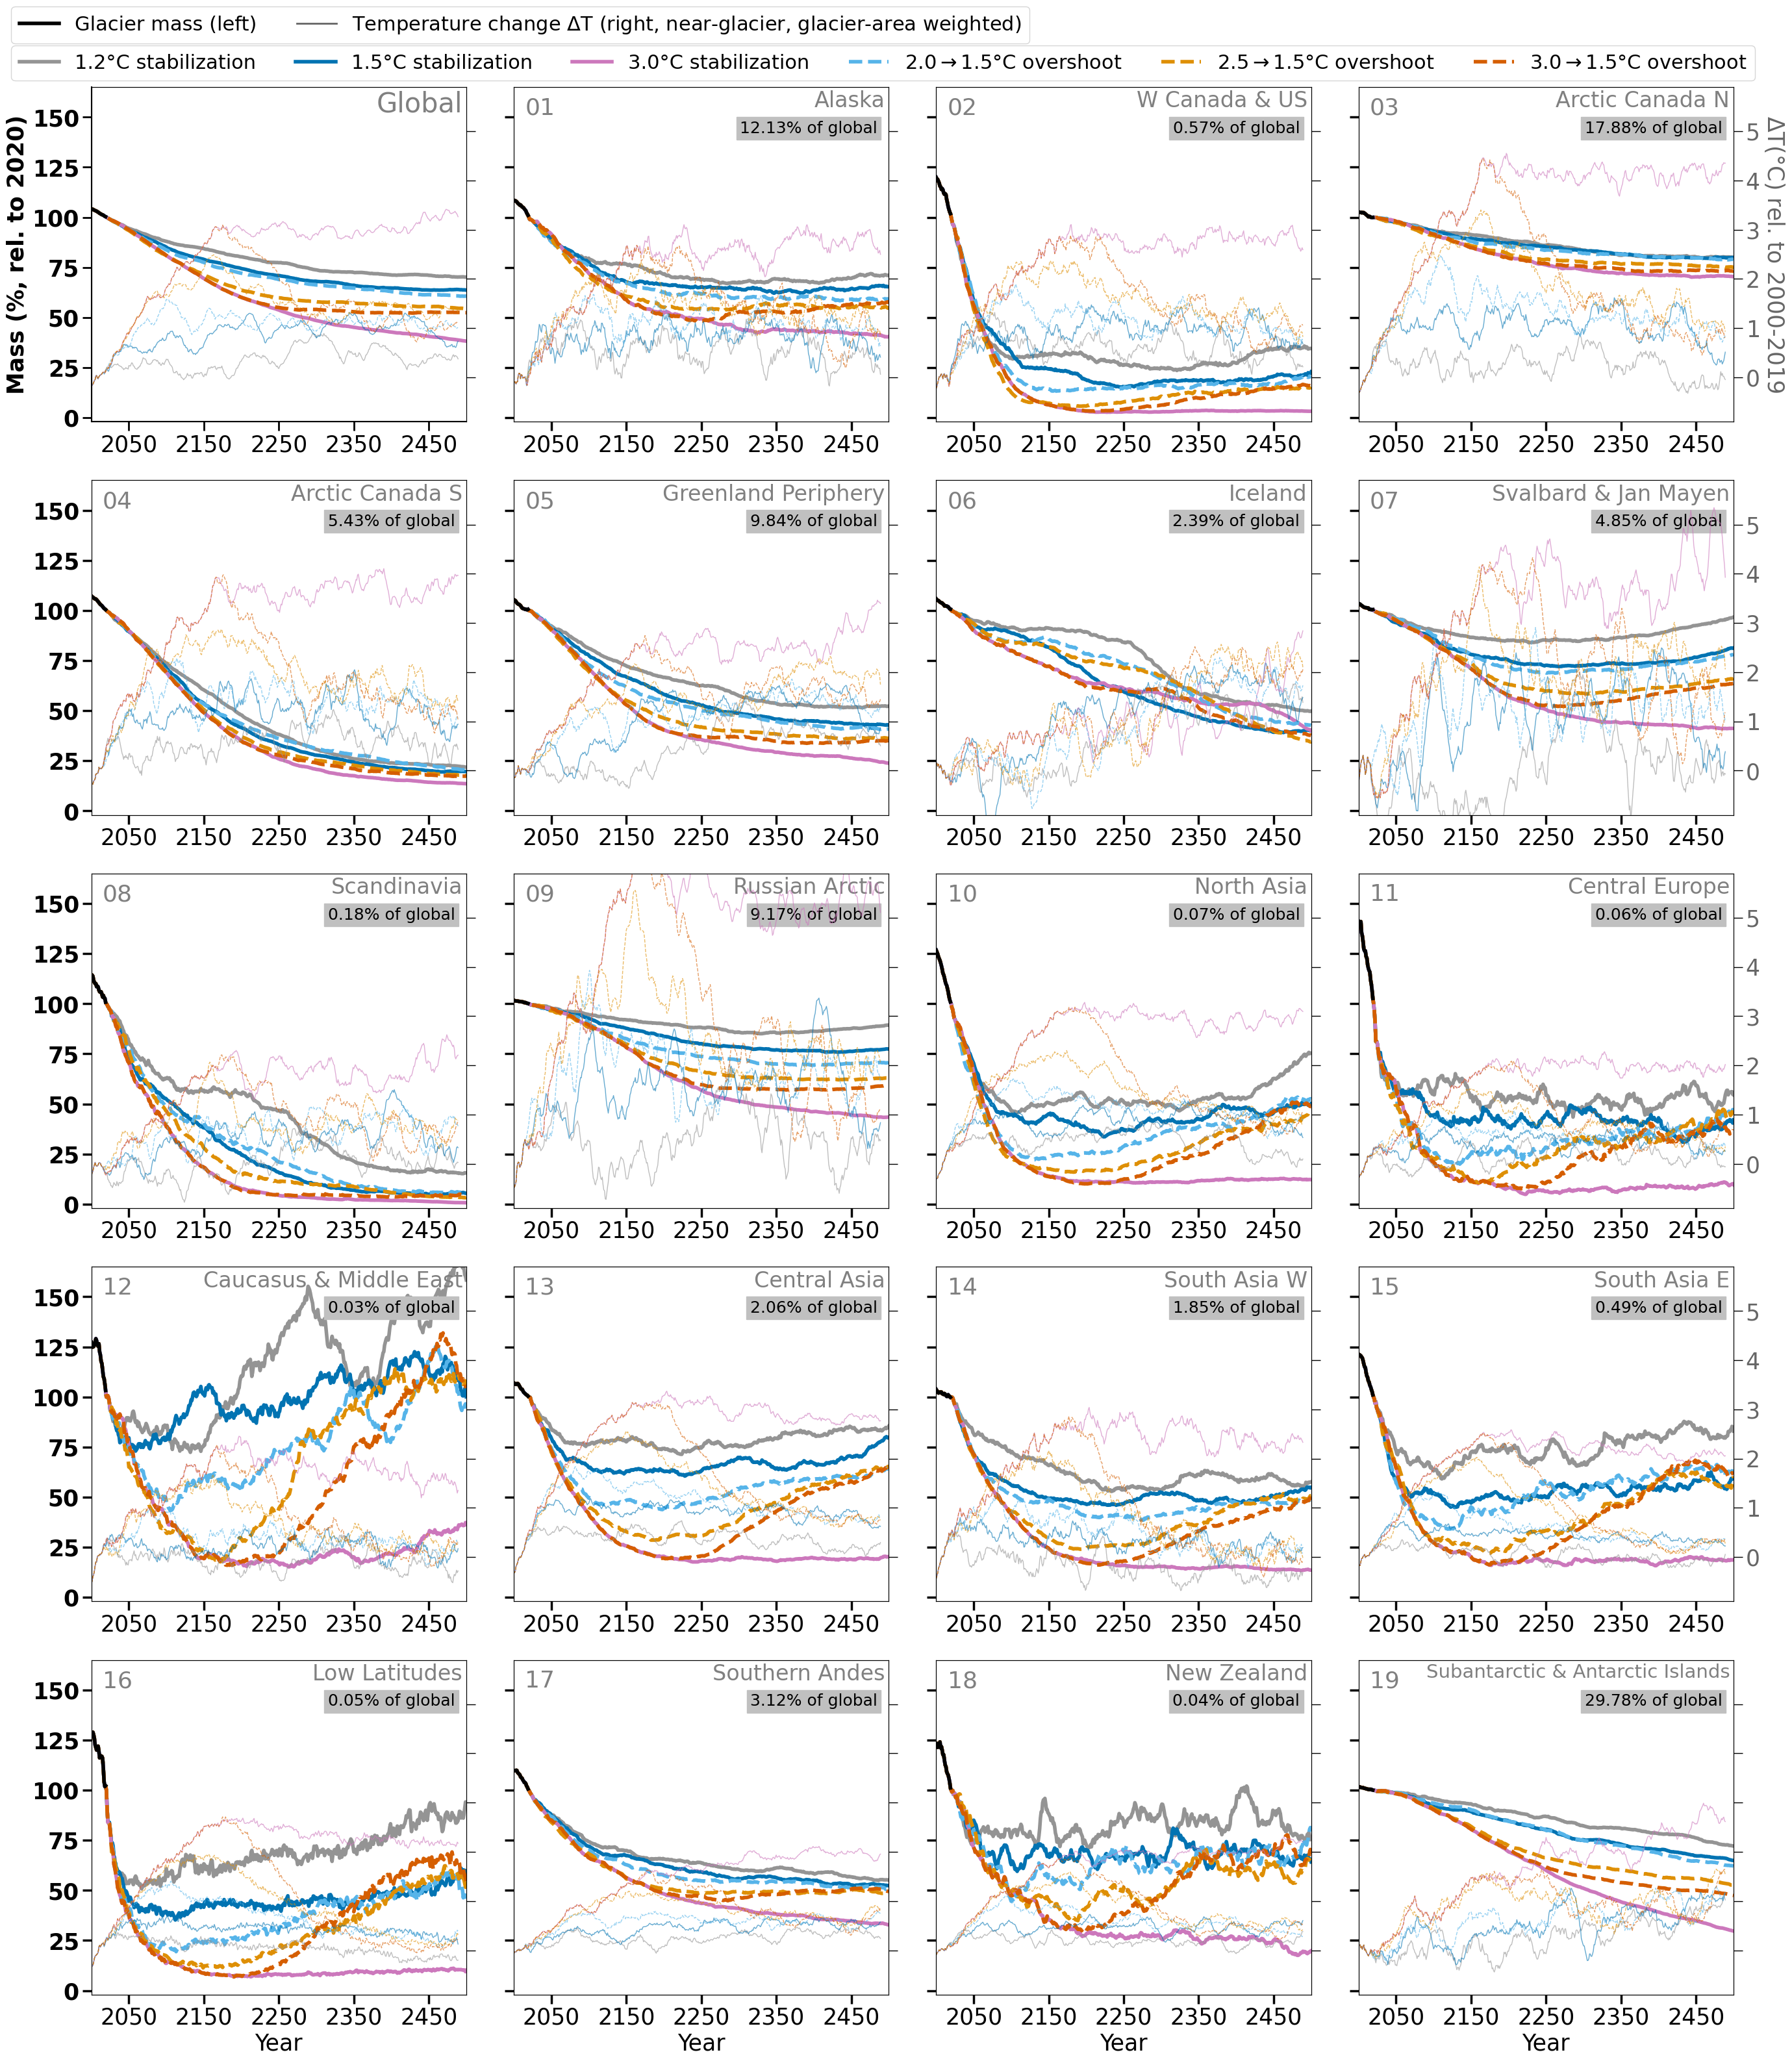

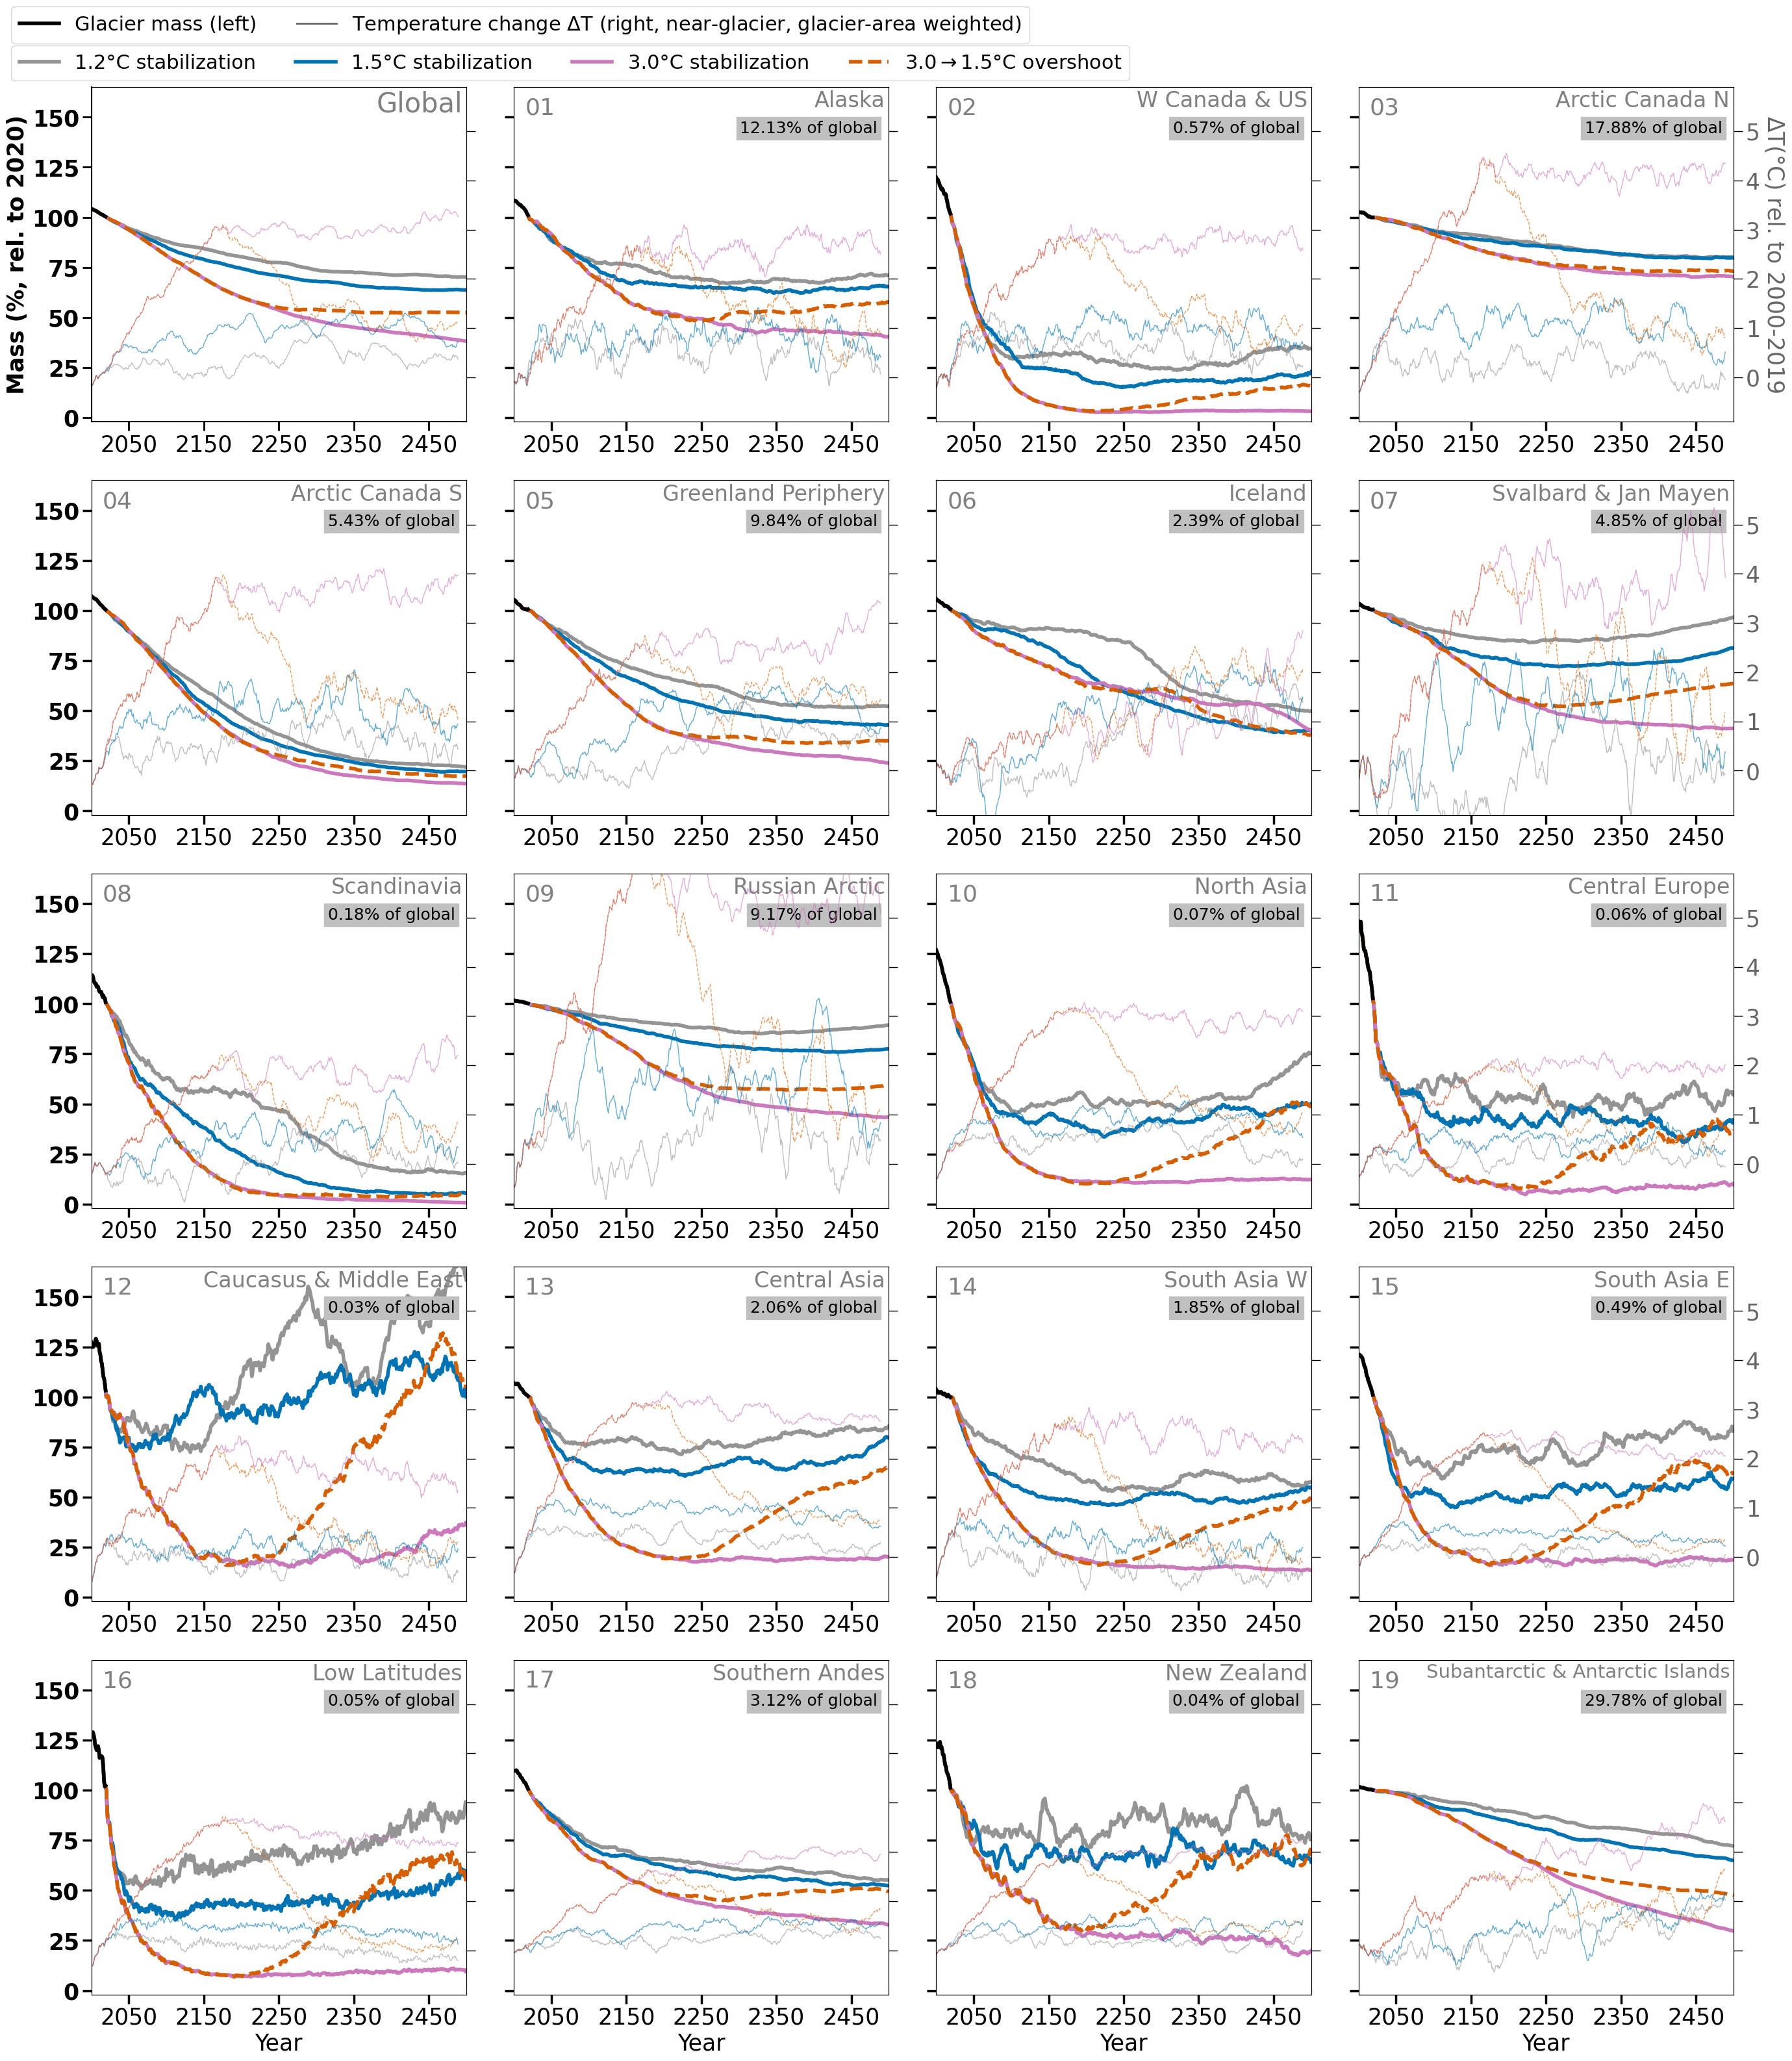

In [21]:
var = 'temp_21yr_avg'

plt.rc('font', size=25)
portrait = True
pd_vol_scenario_rel = (100*df_scenario/df_scenario.sel(time=2020)).volume.to_dataframe('volume_rel_2020_%').reset_index()
df_scenario_glob = df_scenario.sum(dim='rgi_reg')
pd_vol_scenario_glob = (100*df_scenario_glob/df_scenario_glob.sel(time=2020)).volume.to_dataframe('volume_rel_2020_%').reset_index()

for a,color_scenarios in zip(['_all_overshoots', '_poster_iugg'],
                       [color_scenario_all_oversh, color_scenario_poster]):
    scenarios = color_scenarios.keys()
    paletti = list(color_scenarios.values())  
    if portrait:
        plt.figure(figsize=(28,32)) #, sharey=True, sharex=True)
        plt.subplot(5,4,1)
    else:
        plt.figure(figsize=(45,16)) #, sharey=True, sharex=True)
        plt.subplot(2,7,1)
    ax = plt.gca()
    #ax.set_title('Globally')
    #plt.text(0.03,0.97, 'Globally',
    #         transform=ax.transAxes,ha='left',va='top',
    #         color='grey', fontsize=25)
    
    
    sns.lineplot(data=pd_vol_scenario_glob.loc[(pd_vol_scenario_glob.bias_correction=='bc_1980_2019') & 
                                                 (pd_vol_scenario_glob.scenario!='oversh_T20OS15') & 
                                                 (pd_vol_scenario_glob.scenario!='oversh_T25OS15') & 
                                                 (pd_vol_scenario_glob.scenario!='oversh_T30OS15') 
                                                 ],
                 hue='scenario', x='time', y= 'volume_rel_2020_%', 
                 palette=paletti,
             hue_order=scenarios,lw=4, legend=True,
             ax = ax)
    sns.lineplot(data=pd_vol_scenario_glob.loc[(pd_vol_scenario_glob.bias_correction=='bc_1980_2019') & 
                                                 ((pd_vol_scenario_glob.scenario=='oversh_T20OS15') | 
                                                 (pd_vol_scenario_glob.scenario=='oversh_T25OS15') |
                                                 (pd_vol_scenario_glob.scenario=='oversh_T30OS15')) 
                                                 ],
                 hue='scenario', x='time', y= 'volume_rel_2020_%', 
                 ls = '--',
                 palette=paletti,
             hue_order=scenarios,lw=4, legend=True,
             ax = ax)
    sns.lineplot(data=pd_vol_scenario_glob.loc[(pd_vol_scenario_glob.bias_correction=='bc_1980_2019')
                                               #& (pd_vol_scenario_glob.scenario != 'oversh_T30OS15') 
                                               & (pd_vol_scenario_glob.time<2020)],
             x='time', y= 'volume_rel_2020_%', 
             color='black',
             #alpha = alpha,
             #palette=stabs_col,
             #hue_order=stabs,
             lw=4, legend=False,
             ax = ax)

    
    
    ax.set_ylabel('Mass (%, rel. to 2020)', weight='bold')

    #ax.set_xlabel('Year')
    #ax.grid(axis='x')
    ax.set_ylim([-2,165]);
    ax.set_yticks(ticks=[0,25,50,75,100,125, 150],
                       labels=[0,25,50,75,100,125, 150], weight='bold', alpha = 1)

    for axis in 'left', 'bottom':
        ax.spines[axis].set_linewidth(1.5)

    # set the parameters for both axis: label size in font points, the line tick line 
    # width and length in pixels
    ax.tick_params(axis='both', which='major', width=2, length=10,grid_alpha =0)
    ax2 = ax.twinx()  
    for scenario in scenarios:

        pd_clim_scenario = pd_clim_all.loc[pd_clim_all.scenario==scenario]
        pd_clim_scenario_g = pd_clim_scenario.loc[pd_clim_scenario.region == 'global_glacier']
        pd_clim_scenario_g.index = pd_clim_scenario_g.year
        temp_ref_g, precip_ref_g = pd_clim_scenario_g.loc[2000:2019][['temp','precip']].mean()
        var_g_to_ref = pd_clim_scenario_g[var] - temp_ref_g

        ax2.plot(pd_clim_scenario_g.year,
                 var_g_to_ref,
                 alpha = 0.6, 
                 ls = scenario_ls[scenario],
                 lw=1, color = color_scenario[scenario], label=label_scenario[scenario])
    ax2.set_ylabel('')

    ax2.set_yticks(ticks=[0,1,2,3,4,5],
                   labels=[0,1,2,3,4,5], alpha=0.6)
    ax2.set_ylim([-0.9,5.9]);

    plt.setp(ax2.get_yticklabels(), visible=False, fontsize=1)
    ax.set_xlabel('')
    ax.set_xlim([2000,2500])
    ax2.set_xlim([2000,2500])
    ax2.tick_params(axis='both', which='major', width=1, length=10, grid_alpha =0)
    ax.set_xticks([2050,2150,2250,2350,2450],[2050,2150,2250,2350,2450])
    
    ax.text(0.99,0.99, 'Global',
                 transform=ax.transAxes,ha='right',va='top',
                 color='grey', fontsize=30)
    ### add legends
    handles, labels = ax.get_legend_handles_labels()
    handles_2, labels_2 = ax2.get_legend_handles_labels()
    ax.get_legend().remove()
    ax_leg = ax
    for s, h in zip(scenarios, handles):
        if 'oversh' in s: 
            h.set_linestyle('--')
    
    #ax.set_axis_off()
    #ax2.set_axis_off()
    perc_init_l = []
    for j, pi in enumerate(np.arange(1,20,1)):
        j = j+1
        if pi<10:
            Preg = f'0{pi}'
        else:
            Preg = f'{pi}'
        if portrait:
            plt.subplot(5,4,j+1) # + +1
            x_j = np.arange(0,19,4)
            x2_j = np.arange(3,19,4)
            year_xlabel_condi = j>15

        else:
            plt.subplot(2,7,j+1)
            x_j = [6]
            x2_j = [5,12]
            year_xlabel_condi = j>5
        
        ax = plt.gca()

        pd_vol_scenario_rel_reg = pd_vol_scenario_rel.loc[pd_vol_scenario_rel.rgi_reg==Preg]
        sns.lineplot(data=pd_vol_scenario_rel_reg.loc[(pd_vol_scenario_rel_reg.bias_correction=='bc_1980_2019') & 
                                                     (pd_vol_scenario_rel_reg.scenario!='oversh_T20OS15') & 
                                                     (pd_vol_scenario_rel_reg.scenario!='oversh_T25OS15') & 
                                                     (pd_vol_scenario_rel_reg.scenario!='oversh_T30OS15') 
                                                     ],
                     hue='scenario', x='time', y= 'volume_rel_2020_%', 
                     palette=paletti,
                 hue_order=scenarios,lw=4, legend=False,
                 ax = ax)
        sns.lineplot(data=pd_vol_scenario_rel_reg.loc[(pd_vol_scenario_rel_reg.bias_correction=='bc_1980_2019') & 
                                                     ((pd_vol_scenario_rel_reg.scenario=='oversh_T20OS15') | 
                                                     (pd_vol_scenario_rel_reg.scenario=='oversh_T25OS15') |
                                                     (pd_vol_scenario_rel_reg.scenario=='oversh_T30OS15')) 
                                                     ],
                     hue='scenario', x='time', y= 'volume_rel_2020_%', 
                     ls = '--',
                     palette=paletti,
                 hue_order=scenarios,lw=4, legend=False,
                 ax = ax)
        sns.lineplot(data=pd_vol_scenario_rel_reg.loc[(pd_vol_scenario_rel_reg.bias_correction=='bc_1980_2019')
                                                   #& (pd_vol_scenario_glob.scenario != 'oversh_T30OS15') 
                                                   & (pd_vol_scenario_rel_reg.time<2020)],
                 x='time', y= 'volume_rel_2020_%', 
                 color='black',
                 #alpha = alpha,
                 #palette=stabs_col,
                 #hue_order=stabs,
                 lw=4, legend=False,
                 ax = ax)
        #ax.set_title(f'{Preg}')
        plt.text(0.03,0.97, Preg,
                 transform=ax.transAxes,ha='left',va='top',
                 color='grey', fontsize=26)
        if Preg == '19':
            fs_reg = 21
        else:
            fs_reg = 24
        plt.text(0.99,0.99, d_reg_num_name[Preg],
                 transform=ax.transAxes,ha='right',va='top',
                 color='grey', fontsize=fs_reg)
        ax.set_yticks(ticks=[0,25,50,75,100,125,150],
                       labels=[0,25,50,75,100,125,150], weight='bold')
        if j in x_j:
            #plt.ylabel(f'Volume (% relative to 2020)', weight='bold')
            plt.ylabel('')
            ax.set_yticks(ticks=[0,25,50,75,100,125,150],
                       labels=[0,25,50,75,100,125,150], weight='bold')
        else:
            plt.ylabel('')
            ax.set_yticks(ticks=[0,25,50,75,100,125, 150],
                       labels=[0,25,50,75,100,125, 150], alpha=0, fontsize=1) #visible=False) 
            #plt.setp(ax.get_yticklabels(), visible=False)

        ax.set_ylim([-2,165]);
        ax.tick_params(axis='both', which='major', width=2.5, length=10)
        ax2 = ax.twinx()  
        for scenario in scenarios:
                        #'stab_T30']:

            pd_clim_scenario = pd_clim_all.loc[pd_clim_all.scenario==scenario]
            pd_clim_scenario_g = pd_clim_scenario.loc[pd_clim_scenario.region == f'RGI{Preg}_glacier']
            pd_clim_scenario_g.index = pd_clim_scenario_g.year
            temp_ref_g, precip_ref_g = pd_clim_scenario_g.loc[2000:2019][['temp','precip']].mean()
            var_g_to_ref = pd_clim_scenario_g[var] - temp_ref_g

            ax2.plot(pd_clim_scenario_g.year,
                     var_g_to_ref,
                     alpha = 0.6, 
                     ls = scenario_ls[scenario],
                     lw=1, color = color_scenario[scenario], label=label_scenario[scenario])

        ax2.set_yticks(ticks=[0,1,2,3,4,5],
                   labels=[0,1,2,3,4,5], alpha=0.6)
        if j in x2_j:
            if j == 3: 
                ax2.set_ylabel(r'$\Delta$T'+'(°C) rel. to 2000-2019', #\n(glacier-area weighted)',
                              alpha = 0.6, rotation=270)
                ax2.yaxis.set_label_coords(1.14, 0.5) 
            else:
                ax2.set_ylabel('')
            #ax2.set_yticks(labels=[0,1,2,3,4], alpha=0.6)
        else:
            ax2.set_ylabel('')
            #ax2.set_yticks([])
            plt.setp(ax2.get_yticklabels(), visible=False, fontsize=1)

        ax2.set_ylim([-0.9,5.9]);
        if year_xlabel_condi:
            ax.set_xlabel('Year')
        else:
            ax.set_xlabel('')
        if j ==15:
            ax15 = ax
        ax.set_xlim([2000,2500])
        ax.set_xticks([2050,2150,2250,2350,2450],[2050,2150,2250,2350,2450])
        ax2.set_xlim([2000,2500])
        ax2.tick_params(axis='both', which='major', width=1, length=10, grid_alpha =0.6)  
        if j == 0:
            ax.set_ylabel('Mass (%, rel. to 2020)', weight='bold')
            
        _init = df_scenario.volume.sel(time=2020).sel(rgi_reg=Preg).mean()
        init = _init.mean()
        #init = init_sel_sum.mean() #df_scenario_common_cluster.sel(time=2020).mean() # all 8 scenarios are anyways equal (as we use here the non-rolling average!!!)
        assert (_init.std()/init).values <1e-3
        init_all = df_scenario.volume.sel(time=2020).sum(dim='rgi_reg').mean()  # make sure to use here the non-rolling average
        perc_init = np.round(100*init/init_all,2).values
        perc_init_l.append(perc_init)
        #tt = tt + f'\n{perc_init}% initially rel. to global' 
        tt = f'{perc_init}% of global' 

        ax.text(0.97,0.90, tt, 
                transform=ax.transAxes,ha='right',va='top', fontsize=18, color='black',
                backgroundcolor='silver') #, fontweight='bold')
    #np.array(perc_init_l).sum()
    # check if we get to 100
    np.testing.assert_allclose(np.array(perc_init_l).sum() , 100, rtol = 1e-2)
    plt.tight_layout(rect=(0,0,1,0.97))
    
    ax = ax_leg
    leg = ax.legend(handles[:len(scenarios)], labels_2[:len(scenarios)], ncol=6,#title='Scenarios',
                        fontsize=22, #title_fontsize=25, #bbox_to_anchor=(1,1),
                        loc = 'lower left', bbox_to_anchor=(-0.24,0.99))
    for l in leg.get_lines():
        l.set_linewidth(4)
    leg2 = ax.legend([handles[0], handles_2[0]], ['Glacier mass (left)',
                                                  r'Temperature change $\Delta$T'+f' (right, near-glacier, glacier-area weighted)'],
                     loc='lower left', ncol=2, fontsize=22, bbox_to_anchor=(-0.24,1.10)) #, bbox_to_anchor=(1,-0.05),)
    leg2.get_lines()[0].set_linewidth(4)
    leg2.get_lines()[1].set_linewidth(2)
    for l in leg2.get_lines():
        l.set_color('black')
    ax.add_artist(leg)
    #ax15.set_xlabel('Year')
    if 'all_overshoot' in a:
        plt.savefig(f'../figures/ED_fig_3_rgi_reg_volume_changes_overshoot{a}_{bc}_portrait_4cols.pdf', dpi=300)
        plt.savefig(f'../figures/ED_fig_3_rgi_reg_volume_changes_overshoot{a}_{bc}_portrait_4cols.png', dpi=300)
        plt.savefig(f'../figures/ED_fig_3_rgi_reg_volume_changes_overshoot{a}_{bc}_portrait_4cols.jpg', dpi=300)
    else:
        plt.savefig(f'../figures/variant_ED_fig_3_rgi_reg_volume_changes_overshoot{a}_{bc}_portrait_4cols.pdf', dpi=300)
        plt.savefig(f'../figures/variant_ED_fig_3_rgi_reg_volume_changes_overshoot{a}_{bc}_portrait_4cols.png', dpi=300)
        plt.savefig(f'../figures/variant_ED_fig_3_rgi_reg_volume_changes_overshoot{a}_{bc}_portrait_4cols.jpg', dpi=300)


### Precipitation changes

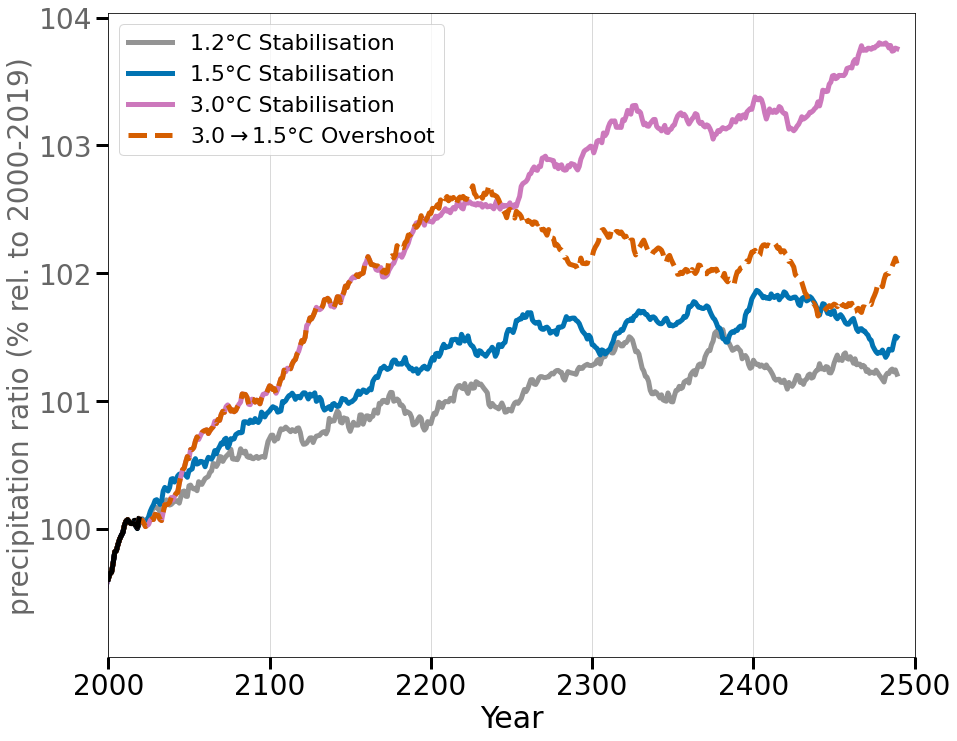

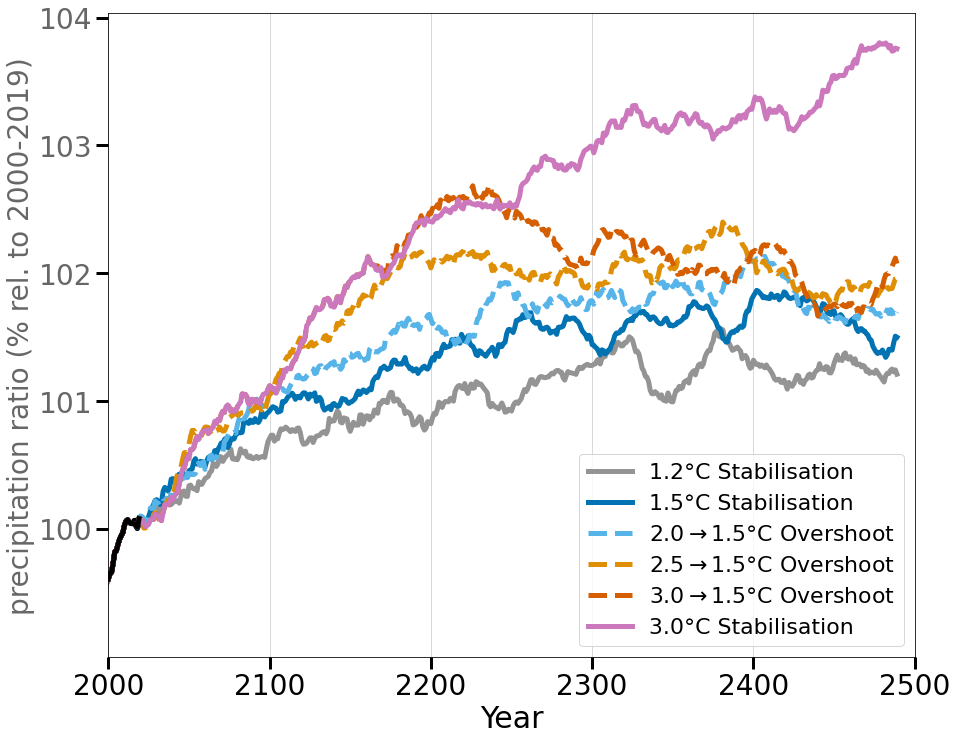

In [17]:
plt.rc('font', size=30)
for a,scenarios in zip([#'_all', 
                        '_poster_iugg', '_all_overshoots'],
                       [#color_scenario.keys(),
                        color_scenario_poster.keys(),
                        ['stab_T12',  'stab_T15', 'oversh_T20OS15', 'oversh_T25OS15','oversh_T30OS15','stab_T30']
                        ]): #'commitment run (2000-2019)',
        
    for j,var in enumerate(['precip_21yr_avg']):
        fig, axs = plt.subplots(1,1, figsize=(14,11))

        #####################
        ax = axs #[0]

        ax2 = ax # .twinx()    
        for scenario in scenarios:
                        #'stab_T30']:

            pd_clim_scenario = pd_clim_all.loc[pd_clim_all.scenario==scenario]
            pd_clim_scenario_g = pd_clim_scenario.loc[pd_clim_scenario.region == 'global']
            pd_clim_scenario_g.index = pd_clim_scenario_g.year
            temp_ref_g, precip_ref_g = pd_clim_scenario_g.loc[2000:2019][['temp','precip']].mean()

            var_g_to_ref = 100*pd_clim_scenario_g[var]/precip_ref_g
            if 'oversh' in scenario:
                ls = '--'
            elif 'stab' in scenario:
                ls = '-.'
            else:
                ls = '-'
            ax2.plot(pd_clim_scenario_g.year,
                     var_g_to_ref, ls = scenario_ls[scenario],
                     lw=5, color = color_scenario[scenario], label=label_scenario[scenario])
            ax2.plot(pd_clim_scenario_g.year.loc[2000:2019],
                     var_g_to_ref.loc[2000:2019], 
                     lw=5, color = 'black')
            #ax.axhline(1.5, color = 'grey', lw = 3, ls = '--')

        ax2.set_yticks(ticks=[100, 101, 102,103,104],
                           labels=[100, 101, 102,103,104], alpha=0.6)   
        ax2.tick_params(axis='both', which='major', width=1, length=10, grid_alpha =0.6)

        handles, labels = ax.get_legend_handles_labels()
        if a=='':
            ncol=1
            leg = ax.legend(handles[:len(scenarios)], labels[:len(scenarios)],
                            title='scenarios reaching +1.5°C\n(20-year average)', ncol=ncol)

        else:
            ncol=2
            if a=='_all':
                fontsize=22
            else:
                fontsize=22
            leg = ax.legend(handles[:len(scenarios)], labels[:len(scenarios)],ncol=1, fontsize=fontsize) #, title='Scenarios:')
            #for handle in handles:
            #    handle.set_linewidth(0.5)  # Set the handle linewidth
        #if var != 'temp_20yr_avg':
        #leg.remove()
        #ax.grid()
        ax.set_xlabel('Year')
 
        #ax.set_ylabel(r'precipitation ratio (relative to preindustrial levels)', weight='bold')
        ax2.set_ylabel(r'precipitation ratio (% rel. to 2000-2019)', alpha =0.6,fontsize=28)
        #ax.set_title(r'Global precipitation changes')
        ax.set_title('')
        plt.tight_layout()
        plt.xlim([2000,2500])
        ax.grid(axis='x')
        ax.tick_params(axis='both', which='major', width=3, length=12)
        plt.yticks(fontsize=28)
        plt.xticks(fontsize=28)

        #ax2.yticks(fontsize=26)

        #plt.savefig(f'over_stab_temp_glob_reg_{basin}.pdf')
        #plt.savefig(f'over_stab_temp_glob_reg_{basin}.png')
        plt.tight_layout()
        #plt.savefig(f'1_global_clim{a}_{var}.pdf')
        plt.savefig(f'../figures/suppl_1_global_clim{a}_{var}.png', dpi=300)

# Other Fig. 2 variants

**two-column approach --> old**

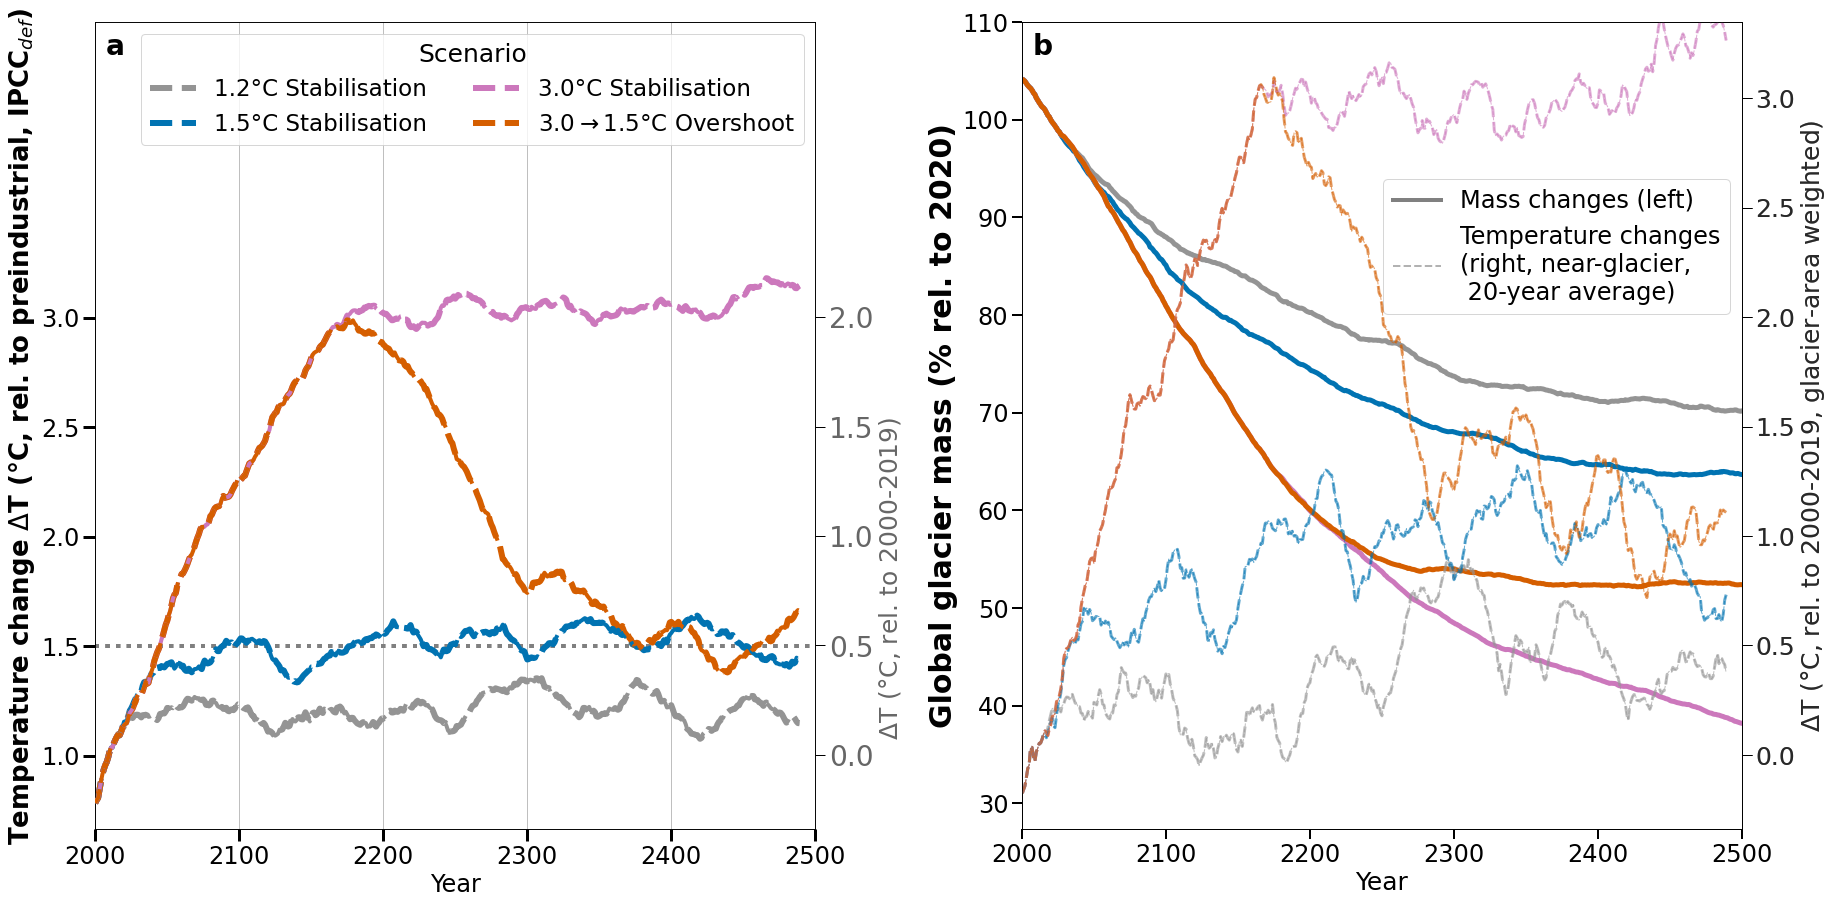

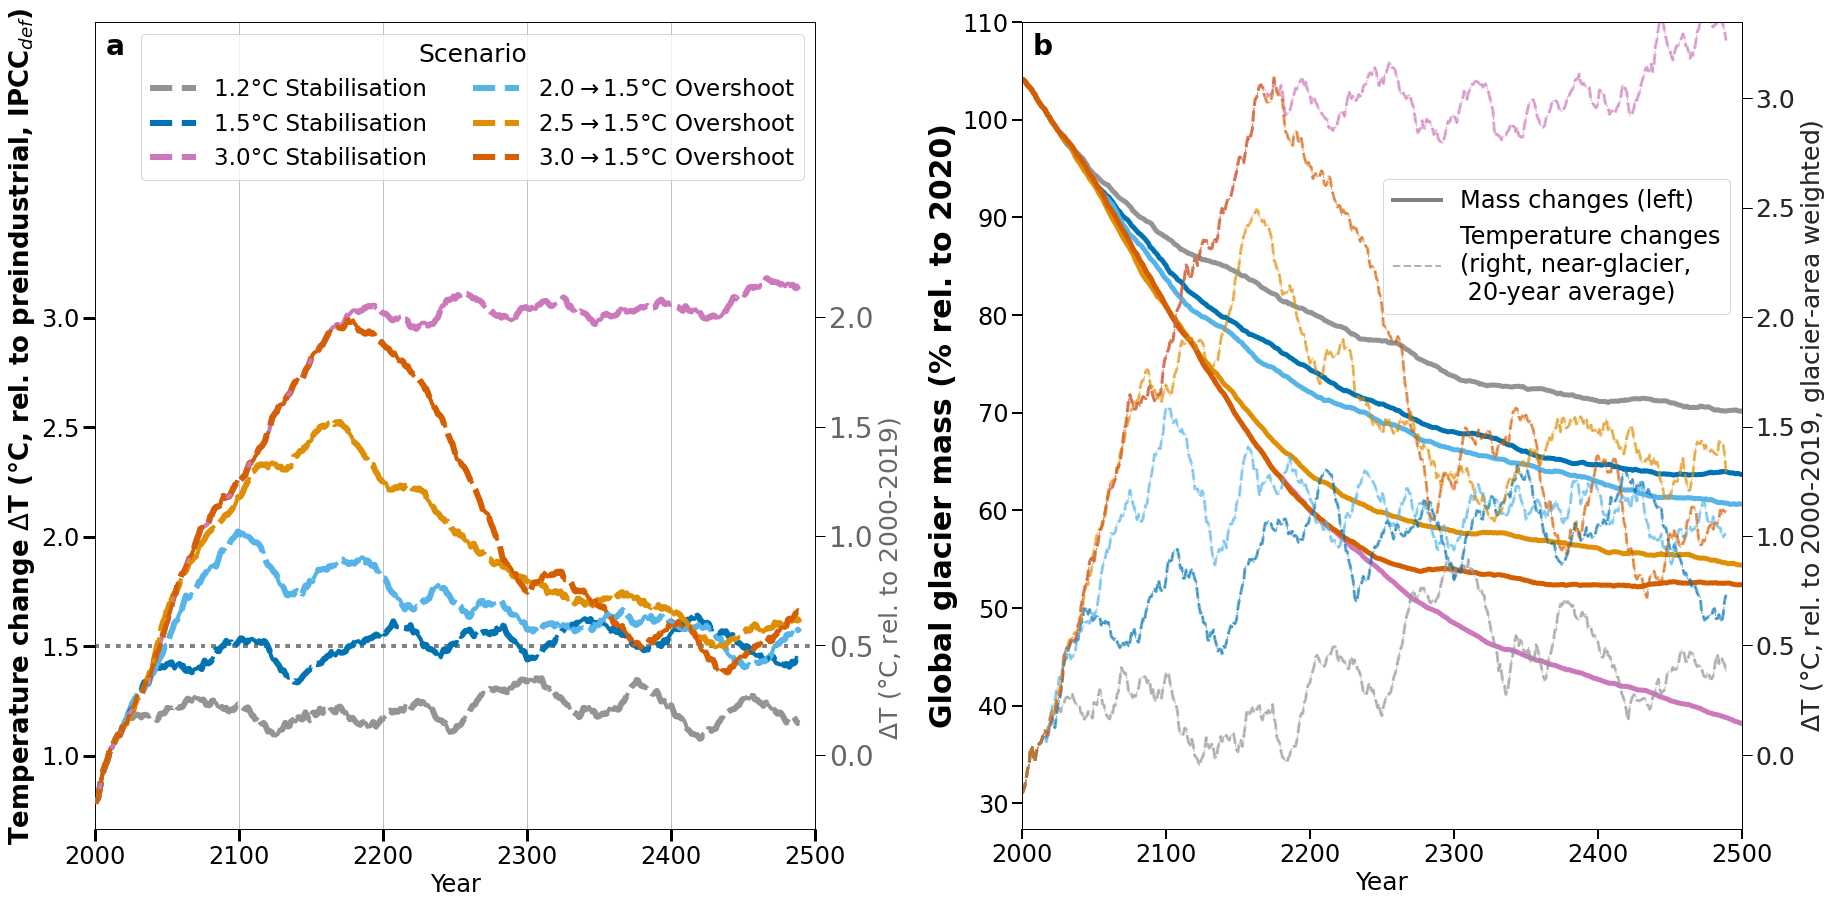

In [18]:
plt.rc('font', size=24)
fs = 25
shift = 1.05
for a,c_scenarios in zip([#'_all', 
                        '_poster_iugg',
                        '_all_overshoots'],
                       [#color_scenario.keys(),
                        color_scenario_poster, 
                        color_scenario_all_oversh]): #'commitment run (2000-2019)',
    scenarios = c_scenarios.keys()
    for j,var in enumerate(['temp_21yr_avg',
                            #'precip_20yr_avg'
                           ]):
        fig, axs = plt.subplots(1,2, figsize=(26,13))

        #####################
        ax = axs[0] #[0]
        for scenario in scenarios:
                        #'stab_T30']:

            pd_clim_scenario = pd_clim_all.loc[pd_clim_all.scenario==scenario]
            pd_clim_scenario_g = pd_clim_scenario.loc[pd_clim_scenario.region == 'global']
            pd_clim_scenario_g.index = pd_clim_scenario_g.year
            pd_clim_scenario_g_ref = pd_clim_scenario_g.loc[1986:2005]['temp'].mean()
            
            if var == 'temp_21yr_avg':
                var_g_to_ref = pd_clim_scenario_g[var]- pd_clim_scenario_g_ref + 0.69
                if 'commit' in scenario:
                    pd_clim_scenario = pd_clim_all.loc[pd_clim_all.scenario=='stab_T15']
                    pd_clim_scenario_g = pd_clim_scenario.loc[pd_clim_scenario.region == 'global']
                    pd_clim_scenario_g.index = pd_clim_scenario_g.year
                    pd_clim_scenario_g_ref = pd_clim_scenario_g.loc[1986:2005]['temp'].mean()
                    var_g_to_ref = mean_2000_2019_avg - pd_clim_scenario_g_ref + 0.69
                    var_g_to_ref = np.repeat(var_g_to_ref,len(np.arange(1979,2500,1)))
                #var_g_to_ref = pd_clim_scenario_g[var]/precip_ref_g
                if 'oversh' in scenario:
                    ls = '--'
                elif 'stab' in scenario:
                    ls = '--'
                else:
                    ls = '--'
                ax.plot(np.arange(2000,2500,1), #pd_clim_scenario_g.year,
                        var_g_to_ref.loc[2000:],
                        ls = ls,
                         lw=6, color = color_scenario[scenario], label=label_scenario[scenario], zorder=5)
                ax.set_xlabel('Year')
                ax.set_title(scenario)
                ax.axhline(1.5, color = 'grey', lw = 4, ls = ':')
                ax.set_yticks(ticks=[1.0,1.5,2.0, 2.5, 3.0],
                           labels=[1.0,1.5,2.0, 2.5, 3.0])   
            else:
                ax.set_yticks([],[])
        ylim_ax = ax.get_ylim()
        ax.set_ylim([ylim_ax[0], ylim_ax[1]+shift])
        ax2 = ax.twinx()    
        for scenario in scenarios:
                        #'stab_T30']:

            pd_clim_scenario = pd_clim_all.loc[pd_clim_all.scenario==scenario]
            pd_clim_scenario_g = pd_clim_scenario.loc[pd_clim_scenario.region == 'global']
            pd_clim_scenario_g.index = pd_clim_scenario_g.year
            temp_ref_g, precip_ref_g = pd_clim_scenario_g.loc[2000:2019][['temp','precip']].mean()
            if var == 'temp_21yr_avg':
                var_g_to_ref = pd_clim_scenario_g[var] - temp_ref_g
            else:
                var_g_to_ref = 100*pd_clim_scenario_g[var]/precip_ref_g
            if 'oversh' in scenario:
                ls = '--'
            elif 'stab' in scenario:
                ls = '-.'
            else:
                ls = '-'
            ax2.plot(pd_clim_scenario_g.year.loc[2000:],
                     var_g_to_ref.loc[2000:], ls = ls,
                     lw=4, color = color_scenario[scenario], label=label_scenario[scenario],
                    zorder=5)
            #ax.axhline(1.5, color = 'grey', lw = 3, ls = '--')
        if var == 'temp_21yr_avg':
            ax2.set_yticks(ticks=[0.0,0.5,1.0,1.5,2.0],
                           labels=[0.0,0.5,1.0,1.5,2.0], alpha=0.6, fontsize=fs)   
        else:
            ax2.set_yticks(ticks=[100, 101, 102,103,104],
                           labels=[100, 101, 102,103,104], alpha=0.6, fontsize=fs)   
        ax2.tick_params(axis='both', which='major', width=1, length=10, grid_alpha =0.6)
        ylim_ax2 = ax2.get_ylim()
        ax2.set_ylim([ylim_ax2[0], ylim_ax2[1]+shift])
        handles, labels = ax.get_legend_handles_labels()
        if a=='':
            ncol=1
            leg = ax.legend(handles[:len(scenarios)], labels[:len(scenarios)], title='scenarios reaching +1.5°C\n(20-year average)', ncol=ncol)

        else:
            ncol=2
            if a=='_all':
                fontsize=22
            else:
                fontsize=22
            leg = ax.legend(handles[:len(scenarios)], labels[:len(scenarios)],ncol=2,
                            fontsize=23, #fontsize,
                            title = 'Scenario',
                            #fontsize=20,
                            title_fontsize=25,
                            bbox_to_anchor=(1,1), loc='upper right', # TODO
                           ) #, title='Scenarios:')
            #for handle in handles:
            #    handle.set_linewidth(0.5)  # Set the handle linewidth
        if var != 'temp_21yr_avg':
            leg.remove()
        #ax.grid()
        ax.set_xlabel('Year')
        if var == 'temp_21yr_avg':
            #ax.set_ylabel(r'$\Delta$T'+r'(°C) (rel. to preindustrial, IPCC$_{def}$)', weight='bold', fontsize=fs+3)
            ax.set_ylabel(r'Temperature change $\Delta$T'+r' (°C, rel. to preindustrial, IPCC$_{def}$)', weight='bold', fontsize=fs+1)

            ax2.set_ylabel(r'$\Delta$T'+' (°C, rel. to 2000-2019)                                       ', alpha =0.6, fontsize=fs)
            #ax.set_title(r'Global temperature changes ($\Delta$T, 20-year average)', fontsize=32)
            #ax.set_ylim([0,3.2])
        else:
            #ax.set_ylabel(r'precipitation ratio (relative to preindustrial levels)', weight='bold')
            ax2.set_ylabel(r'precipitation ratio (%, relative to 2000-2019)', alpha =0.6,fontsize=fs)
            #ax.set_title(r'Global precipitation changes')
        ax.set_title('')
        plt.tight_layout()
        plt.xlim([2000,2500])
        ax.grid(axis='x')
        ax.tick_params(axis='both', which='major', width=3, length=12)
        plt.yticks(fontsize=28)
        plt.xticks(fontsize=28)
        ylim_ax2 = ax2.get_ylim()

        ##################
        # volume plot
        
        #####
        ax = axs[1]
        color_scenarios = c_scenarios #.keys()) #color_scenario_manuscript
        for alpha in [0,1]: # 0
            if alpha == 0:
                lw_temp =3
            else:
                lw_temp = 1
            scenarios = color_scenarios.keys()
            paletti = list(color_scenarios.values())     
            #fig, ax = plt.subplots(1,1, figsize=(16,10), sharex=True)
            pd_vol_scenario_rel = (100*df_scenario/df_scenario.sel(time=2020)).volume.to_dataframe('volume_rel_2020_%').reset_index()
            df_scenario_glob = df_scenario.sum(dim='rgi_reg')
            pd_vol_scenario_glob = (100*df_scenario_glob/df_scenario_glob.sel(time=2020)).volume.to_dataframe('volume_rel_2020_%').reset_index()

            ax.set_ylabel('Global glacier mass (% rel. to 2020)', weight='bold',alpha = alpha, fontsize=fs+5)

            sns.lineplot(data=pd_vol_scenario_glob.loc[pd_vol_scenario_glob.bias_correction==bc],
                         hue='scenario', x='time', y= 'volume_rel_2020_%', 
                         alpha = alpha,
                         palette=paletti,
                         hue_order=scenarios,lw=5, legend=True,
                         ax = ax)
            ax.set_xlabel('Year',  #weight='bold',
                          fontsize= fs)
            ax.tick_params(axis='both', which='major', width=2, length=10)
            ax.set_yticks(ticks=ax.get_yticks(), alpha=alpha)
            ax.grid(axis='x')
            ax.axhline(31, alpha=0)
            ax2 = ax.twinx()  
            for scenario in scenarios:
                            #'stab_T30']:

                pd_clim_scenario = pd_clim_all.loc[pd_clim_all.scenario==scenario]
                pd_clim_scenario_g = pd_clim_scenario.loc[pd_clim_scenario.region == 'global_glacier']
                pd_clim_scenario_g.index = pd_clim_scenario_g.year
                temp_ref_g, precip_ref_g = pd_clim_scenario_g.loc[2000:2019][['temp','precip']].mean()
                var_g_to_ref = pd_clim_scenario_g[var] - temp_ref_g

                ax2.plot(pd_clim_scenario_g.year,
                         var_g_to_ref,
                         alpha = 0.6, 
                         ls = '--',
                         lw=lw_temp, color = color_scenario[scenario], label=label_scenario[scenario])
            ax2.set_yticks(ticks=[0.0,0.5,1.0,1.5,2.0,2.5,3.0],
                           labels=[0.0,0.5,1.0,1.5,2.0,2.5,3.0], alpha=0.6, fontsize=fs)
            #ax2.set_ylim([-0.9,5.9]);
            ax2.set_ylabel(r'$\Delta$T'+' (°C, rel. to 2000-2019, glacier-area weighted)', alpha =0.6, fontsize = fs);
            ax2.tick_params(axis='both', which='major', width=1, length=10)
            ax2.axhline(-1, alpha=0)
            ax2.axhline(3.7, alpha=0)
            ax2.set_ylim(ylim_ax2)
            #plt.ylim([-2,122]);
            plt.tight_layout()

            ### add legends
            handles, labels = ax.get_legend_handles_labels()
            ax.get_legend().remove()
            handles_2, labels_2 = ax2.get_legend_handles_labels()
            if a == '_poster_iugg':
                leg = ax.legend(handles[:len(scenarios)], labels_2[:len(scenarios)], title='Scenarios',
                                fontsize=20, title_fontsize=22, bbox_to_anchor=(1,0.82), loc='upper right')
            else:
                leg = ax.legend(handles[:len(scenarios)], labels_2[:len(scenarios)], title='Scenarios',
                                fontsize=20, title_fontsize=22, #bbox_to_anchor=(1,1),
                                loc='lower center', ncol=2)
            for l in leg.get_lines():
                l.set_linewidth(4)
            leg.remove()
            if alpha !=0:
                leg2 = ax.legend([handles[0], handles_2[0]], ['Mass changes (left)',
                                                              f'Temperature changes\n(right, near-glacier,\n 20-year average)'],
                                 loc='upper right', ncol=1, fontsize=24,
                                 bbox_to_anchor=(1,0.82),
                                )
                leg2.get_lines()[0].set_linewidth(4)
                leg2.get_lines()[1].set_linewidth(2)
                for l in leg2.get_lines():
                    l.set_color('grey')
            #ax.add_artist(leg)
            #if a == '_poster_iugg':
            #    pass
            #    ax.text(0.98,0.98, 'Globally',
            #             transform=ax.transAxes,ha='right',va='top',
            #             color='grey', fontsize=24)
            #else:
            #ax.set_title('Global glacier volume evolution')

            #plt.tight_layout()
            #plt.savefig(f'2_global_glacier_volume{a}_{bc}_vol{alpha}.pdf')
            #plt.savefig(f'2_global_glacier_volume{a}_{bc}_vol{alpha}.png')
        plt.xlim([2000,2500])

        num_text_x = 0.015
        num_text_y = 0.96
        for j,axi in enumerate(axs):
            axi.text(num_text_x, num_text_y,
                     num_dict[j], fontsize=28, transform=axi.transAxes, zorder=10, weight='bold')
        #ax2.yticks(fontsize=26)

        #plt.savefig(f'over_stab_temp_glob_reg_{basin}.pdf')
        #plt.savefig(f'over_stab_temp_glob_reg_{basin}.png')
        plt.tight_layout()
        #plt.savefig(f'figures/fig_2_temp_vol_glob{a}_{alpha}.pdf')
        #plt.savefig(f'figures/fig_2_temp_vol_glob{a}_{alpha}.png', dpi=300)

**one colunm appproach --> new**

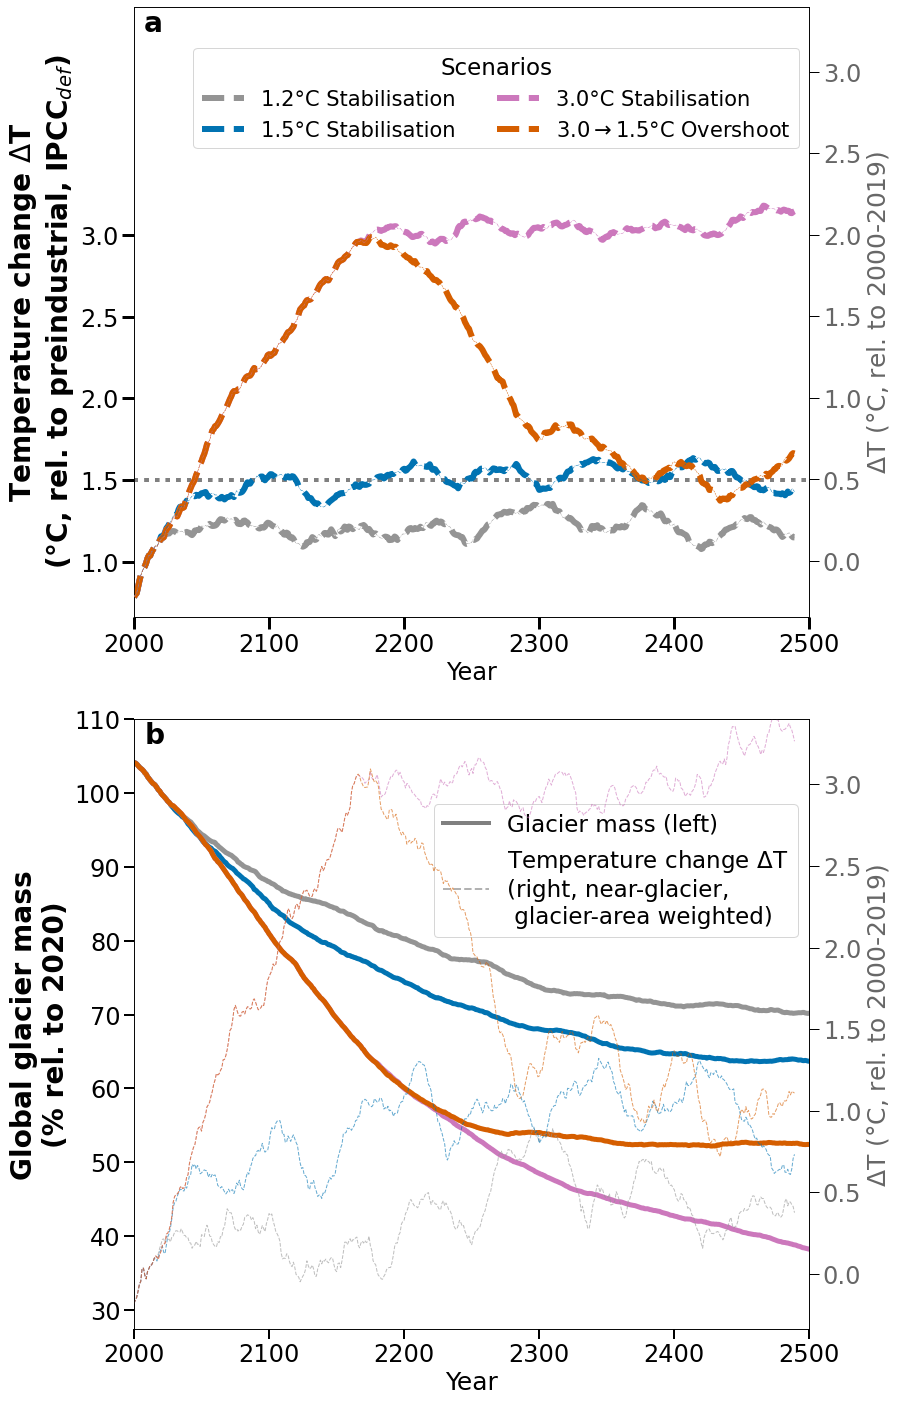

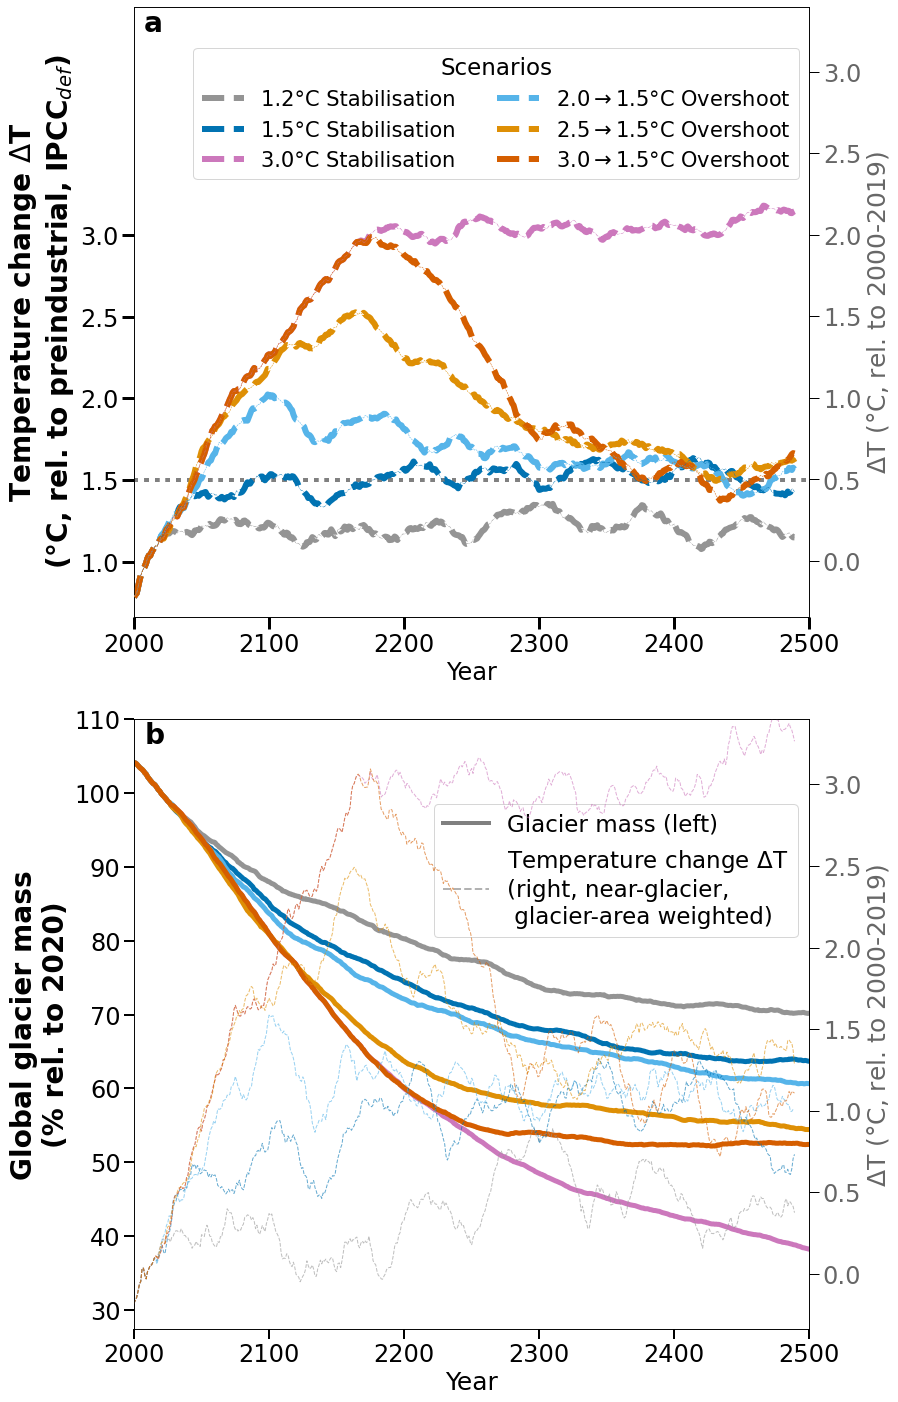

In [19]:
plt.rc('font', size=24)
fs = 25
shift = 1.1
alpha = 1
for a,c_scenarios in zip([#'_all', 
                        '_poster_iugg',
                        '_all_overshoots'],
                       [#color_scenario.keys(),
                        color_scenario_poster, 
                        color_scenario_all_oversh]): #'commitment run (2000-2019)',
    scenarios = c_scenarios.keys()
    for j,var in enumerate(['temp_21yr_avg',
                            #'precip_20yr_avg'
                           ]):
        fig, axs = plt.subplots(2,1, figsize=(13,20))
        #####################
        ax = axs[0] #[0]
        for scenario in scenarios:
                        #'stab_T30']:

            pd_clim_scenario = pd_clim_all.loc[pd_clim_all.scenario==scenario]
            pd_clim_scenario_g = pd_clim_scenario.loc[pd_clim_scenario.region == 'global']
            pd_clim_scenario_g.index = pd_clim_scenario_g.year
            pd_clim_scenario_g_ref = pd_clim_scenario_g.loc[1986:2005]['temp'].mean()

            if var == 'temp_21yr_avg':
                var_g_to_ref = pd_clim_scenario_g[var]- pd_clim_scenario_g_ref + 0.69
                #var_g_to_ref = pd_clim_scenario_g[var]/precip_ref_g
                if 'oversh' in scenario:
                    ls = '--'
                elif 'stab' in scenario:
                    ls = '--'
                else:
                    ls = '--'
                ax.plot(np.arange(2000,2500,1), #pd_clim_scenario_g.year,
                        var_g_to_ref.loc[2000:],
                        ls = ls,
                         lw=6, color = color_scenario[scenario], label=label_scenario[scenario], zorder=5)
                ax.set_xlabel('Year')
                ax.set_title(scenario)
                ax.axhline(1.5, color = 'grey', lw = 4, ls = ':')
                ax.set_yticks(ticks=[1.0,1.5,2.0, 2.5, 3.0],
                           labels=[1.0,1.5,2.0, 2.5, 3.0])   
            else:
                ax.set_yticks([],[])
        ylim_ax = ax.get_ylim()
        ax.set_ylim([ylim_ax[0], ylim_ax[1]+shift])
        ax2 = ax.twinx()    
        for scenario in scenarios:
                        #'stab_T30']:

            pd_clim_scenario = pd_clim_all.loc[pd_clim_all.scenario==scenario]
            pd_clim_scenario_g = pd_clim_scenario.loc[pd_clim_scenario.region == 'global']
            pd_clim_scenario_g.index = pd_clim_scenario_g.year
            temp_ref_g, precip_ref_g = pd_clim_scenario_g.loc[2000:2019][['temp','precip']].mean()
            if var == 'temp_21yr_avg':
                var_g_to_ref = pd_clim_scenario_g[var] - temp_ref_g
            else:
                var_g_to_ref = 100*pd_clim_scenario_g[var]/precip_ref_g
            if 'oversh' in scenario:
                ls = '--'
            elif 'stab' in scenario:
                ls = '-.'
            else:
                ls = '-'
            ax2.plot(pd_clim_scenario_g.year.loc[2000:],
                     var_g_to_ref.loc[2000:], ls = ls,
                     lw=0.5, color = color_scenario[scenario], label=label_scenario[scenario],
                    zorder=5)
            #ax.axhline(1.5, color = 'grey', lw = 3, ls = '--')
        ylim_ax2 = ax2.get_ylim()
        ax2.set_ylim([ylim_ax2[0], ylim_ax2[1]+shift])
        ax2.tick_params(axis='both', which='major', width=1, length=10, grid_alpha =0.6)
        ax2.set_yticks(ticks=[0.0,0.5,1.0,1.5,2.0, 2.5, 3.0],
                           labels=[0.0,0.5,1.0,1.5,2.0, 2.5, 3.0], alpha=0.6, fontsize=fs-1)
        handles, labels = ax.get_legend_handles_labels()
        if a=='':
            ncol=1
            leg = ax.legend(handles[:len(scenarios)], labels[:len(scenarios)], 
                            title='scenarios reaching +1.5°C\n(21-year average)', fontsize=22, ncol=ncol)
        else:
            ncol=2
            if a=='_all':
                fontsize=22
            else:
                fontsize=22
            leg = ax.legend(handles[:len(scenarios)], labels[:len(scenarios)],ncol=2,
                            fontsize=21, #fontsize,
                            title = 'Scenarios',
                            #fontsize=20,
                            title_fontsize=23,
                            bbox_to_anchor=(1,0.95), loc='upper right', # TODO
                           ) #, title='Scenarios:')
            #for handle in handles:
            #    handle.set_linewidth(0.5)  # Set the handle linewidth
        if var != 'temp_21yr_avg':
            leg.remove()
        #ax.grid()
        ax.set_xlabel('Year')
        if var == 'temp_21yr_avg':
            #ax.set_ylabel(r'$\Delta$T'+r'(°C) (rel. to preindustrial, IPCC$_{def}$)', weight='bold', fontsize=fs+3)
            ax.set_ylabel(r'Temperature change $\Delta$T'+'\n'+r'(°C, rel. to preindustrial, IPCC$_{def}$)', weight='bold', fontsize=fs+3)

            ax2.set_ylabel(r'$\Delta$T'+' (°C, rel. to 2000-2019)', alpha =0.6, fontsize=fs)
            #ax.set_title(r'Global temperature changes ($\Delta$T, 20-year average)', fontsize=32)
            #ax.set_ylim([0,3.2])
        else:
            #ax.set_ylabel(r'precipitation ratio (relative to preindustrial levels)', weight='bold')
            ax2.set_ylabel(r'precipitation ratio (%, relative to 2000-2019)', alpha =0.6,fontsize=fs)
            #ax.set_title(r'Global precipitation changes')
        ax.set_title('')
        plt.tight_layout()
        plt.xlim([2000,2500])
        #ax.grid(axis='x')
        ax.tick_params(axis='both', which='major', width=3, length=12)
        #plt.yticks(fontsize=28)
        plt.xticks(fontsize=28)
        ylim_ax2 = ax2.get_ylim()

        #######################
        # volume plot
        #####
        ax = axs[1]
        color_scenarios = c_scenarios #.keys()) #color_scenario_manuscript
        for alpha in [0,1]: # 0
            if alpha == 0:
                lw_temp =3
            else:
                lw_temp = 1
            scenarios = color_scenarios.keys()
            paletti = list(color_scenarios.values())     
            #fig, ax = plt.subplots(1,1, figsize=(16,10), sharex=True)
            pd_vol_scenario_rel = (100*df_scenario/df_scenario.sel(time=2020)).volume.to_dataframe('volume_rel_2020_%').reset_index()
            df_scenario_glob = df_scenario.sum(dim='rgi_reg')
            pd_vol_scenario_glob = (100*df_scenario_glob/df_scenario_glob.sel(time=2020)).volume.to_dataframe('volume_rel_2020_%').reset_index()

            ax.set_ylabel('Global glacier mass\n(% rel. to 2020)', weight='bold',alpha = alpha, fontsize=fs+3)

            sns.lineplot(data=pd_vol_scenario_glob.loc[pd_vol_scenario_glob.bias_correction==bc],
                         hue='scenario', x='time', y= 'volume_rel_2020_%', 
                         alpha = alpha,
                         palette=paletti,
                         hue_order=scenarios,lw=5, legend=True,
                         ax = ax)
            ax.set_xlabel('Year',  #weight='bold','
                          fontsize= fs)
            ax.tick_params(axis='both', which='major', width=2, length=10)
            ax.set_yticks(ticks=ax.get_yticks(), alpha=alpha)
            ax.grid(axis='x')
            ax.axhline(31, alpha=0)

            #plt.ylim([-2,122]);
            plt.tight_layout()

            ### add legends
            handles, labels = ax.get_legend_handles_labels()
            ax.get_legend().remove()
            if a == '_poster_iugg':
                leg = ax.legend(handles[:len(scenarios)], labels_2[:len(scenarios)], title='Scenarios',
                                fontsize=20, title_fontsize=22, bbox_to_anchor=(1,0.82), loc='upper right')
            else:
                leg = ax.legend(handles[:len(scenarios)], labels_2[:len(scenarios)], title='Scenarios',
                                fontsize=20, title_fontsize=22, #bbox_to_anchor=(1,1),
                                loc='lower center', ncol=2)
            for l in leg.get_lines():
                l.set_linewidth(4)
            leg.remove()

            #ax.add_artist(leg)
            #if a == '_poster_iugg':
            #    pass
            #    ax.text(0.98,0.98, 'Globally',
            #             transform=ax.transAxes,ha='right',va='top',
            #             color='grey', fontsize=24)
            #else:
            #ax.set_title('Global glacier volume evolution')

            #plt.tight_layout()
            #plt.savefig(f'2_global_glacier_volume{a}_{bc}_vol{alpha}.pdf')
            #plt.savefig(f'2_global_glacier_volume{a}_{bc}_vol{alpha}.png')

        ax2 = ax.twinx()  
        for scenario in scenarios:
                        #'stab_T30']:

            pd_clim_scenario = pd_clim_all.loc[pd_clim_all.scenario==scenario]
            pd_clim_scenario_g = pd_clim_scenario.loc[pd_clim_scenario.region == 'global_glacier']
            pd_clim_scenario_g.index = pd_clim_scenario_g.year
            temp_ref_g, precip_ref_g = pd_clim_scenario_g.loc[2000:2019][['temp','precip']].mean()
            var_g_to_ref = pd_clim_scenario_g[var] - temp_ref_g

            ax2.plot(pd_clim_scenario_g.year,
                     var_g_to_ref,
                     alpha = 0.6, 
                     ls = '--',
                     lw=lw_temp, color = color_scenario[scenario], label=label_scenario[scenario])
        #ax2.set_yticks(ticks=[0.0,0.5,1.0,1.5,2.0,2.5,3.0],
        #               labels=[0.0,0.5,1.0,1.5,2.0,2.5,3.0], alpha=0.6) #, fontsize=fs)
        
        ax2.tick_params(axis='both', which='major', width=1, length=10, grid_alpha =0.6)
        ax2.set_yticks(ticks=[0.0,0.5,1.0,1.5,2.0, 2.5, 3.0],
                           labels=[0.0,0.5,1.0,1.5,2.0, 2.5, 3.0], alpha=0.6,fontsize=fs-1)   #, fontsize=fs
        #ax2.set_ylim([-0.9,5.9]);
        # ax2.set_ylabel(r'$\Delta$T'+' (°C, rel. to 2000-2019, glacier-area weighted)', alpha =0.6, fontsize = fs);
        ax2.set_ylabel(r'$\Delta$T'+' (°C, rel. to 2000-2019)', alpha =0.6, fontsize=fs)

        #ax2.axhline(-1, alpha=0)
        #ax2.axhline(3.7, alpha=0)
        #ax2.set_ylim(ylim_ax2)
        ax2.set_ylim(ylim_ax2) # 

        if alpha !=0:
            leg2 = ax.legend([handles[0], handles_2[0]], ['Glacier mass (left)',
                                                          r'Temperature change $\Delta$T'+f'\n(right, near-glacier,\n glacier-area weighted)'],
                             loc='upper right', ncol=1, fontsize=23,
                             bbox_to_anchor=(1,0.88),
                            )
            leg2.get_lines()[0].set_linewidth(4)
            leg2.get_lines()[1].set_linewidth(2)
            for l in leg2.get_lines():
                l.set_color('grey')
        plt.xlim([2000,2500])

        num_text_x = 0.015
        num_text_y = 0.96
        for j,axi in enumerate(axs):
            axi.text(num_text_x, num_text_y,
                     num_dict[j], fontsize=28, transform=axi.transAxes, zorder=10, weight='bold')
        #ax2.yticks(fontsize=26)

        #plt.savefig(f'over_stab_temp_glob_reg_{basin}.pdf')
        #plt.savefig(f'over_stab_temp_glob_reg_{basin}.png')
        plt.tight_layout()
        #plt.savefig(f'figures/fig_2_temp_vol_glob{a}_{alpha}_one_column.pdf')
        #plt.savefig(f'figures/fig_2_temp_vol_glob{a}_{alpha}_one_column.png', dpi=300)

**David's suggestion**

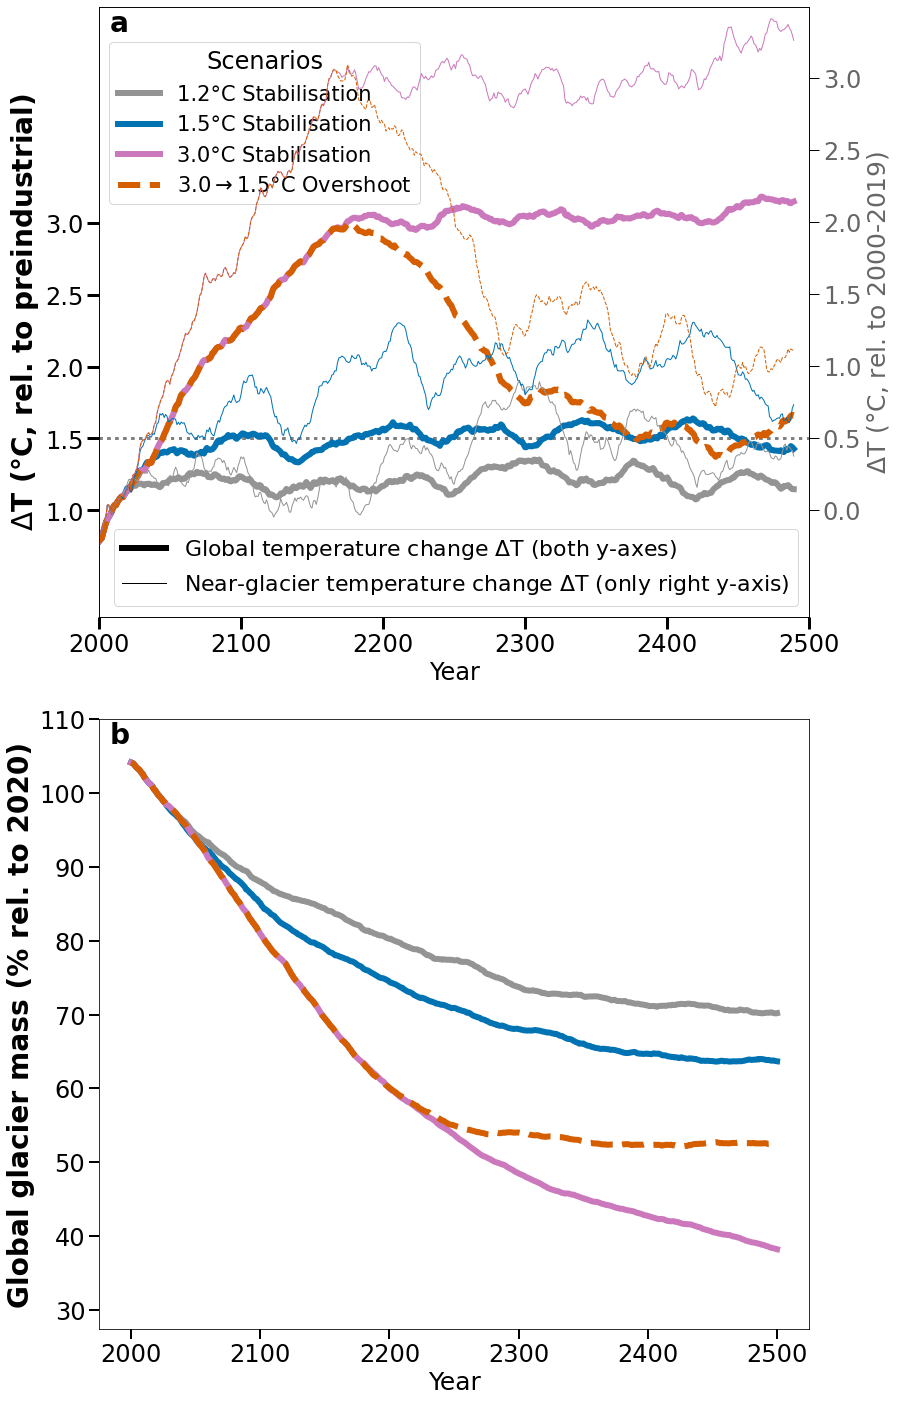

In [20]:
### David's version 

plt.rc('font', size=24)
fs = 25
shift = 1.2
shift_l = -0.4

alpha = 1
for a,c_scenarios in zip([#'_all', 
                        '_poster_iugg'],
                        #,
                        #'_all_overshoots'],
                       [#color_scenario.keys(),
                        color_scenario_poster
                       ]): #color_scenario_all_oversh]): #'commitment run (2000-2019)',
    scenarios = c_scenarios.keys()
    for j,var in enumerate(['temp_21yr_avg',
                            #'precip_20yr_avg'
                           ]):
        fig, axs = plt.subplots(2,1, figsize=(13,20))
        #####################
        ax = axs[0] #[0]
        for scenario in scenarios:
                        #'stab_T30']:

            pd_clim_scenario = pd_clim_all.loc[pd_clim_all.scenario==scenario]
            pd_clim_scenario_g = pd_clim_scenario.loc[pd_clim_scenario.region == 'global']
            pd_clim_scenario_g.index = pd_clim_scenario_g.year
            pd_clim_scenario_g_ref = pd_clim_scenario_g.loc[1986:2005]['temp'].mean()

            if var == 'temp_21yr_avg':
                var_g_to_ref = pd_clim_scenario_g[var]- pd_clim_scenario_g_ref + 0.69
                #var_g_to_ref = pd_clim_scenario_g[var]/precip_ref_g
                if 'oversh' in scenario:
                    ls = '--'
                elif 'stab' in scenario:
                    ls = '--'
                else:
                    ls = '--'
                ax.plot(np.arange(2000,2500,1), #pd_clim_scenario_g.year,
                        var_g_to_ref.loc[2000:],
                        ls = scenario_ls[scenario],
                         lw=6, color = color_scenario[scenario], label=label_scenario[scenario], zorder=5)
                ax.set_xlabel('Year')
                ax.set_title(scenario)
                ax.axhline(1.5, color = 'grey', lw = 3, ls = ':', alpha = 0.8)
                ax.set_yticks(ticks=[1.0,1.5,2.0, 2.5, 3.0],
                           labels=[1.0,1.5,2.0, 2.5, 3.0])   
            else:
                ax.set_yticks([],[])
        ylim_ax = ax.get_ylim()
        ax.set_ylim([ylim_ax[0]+shift_l, ylim_ax[1]+shift])
        ax2 = ax.twinx()    

        for scenario in scenarios:
                        #'stab_T30']:

            pd_clim_scenario = pd_clim_all.loc[pd_clim_all.scenario==scenario]
            pd_clim_scenario_g = pd_clim_scenario.loc[pd_clim_scenario.region == 'global']
            pd_clim_scenario_g.index = pd_clim_scenario_g.year
            temp_ref_g, precip_ref_g = pd_clim_scenario_g.loc[2000:2019][['temp','precip']].mean()
            if var == 'temp_21yr_avg':
                var_g_to_ref = pd_clim_scenario_g[var] - temp_ref_g
            else:
                var_g_to_ref = 100*pd_clim_scenario_g[var]/precip_ref_g
            if 'oversh' in scenario:
                ls = '--'
            elif 'stab' in scenario:
                ls = '-.'
            else:
                ls = '-'
            ax2.plot(pd_clim_scenario_g.year.loc[2000:],
                     var_g_to_ref.loc[2000:], ls = scenario_ls[scenario], #ls,
                     lw=0,  #0.5,  # we actually do not want to see that one... <--- just put that to non-zero for tests ... 
                     color = color_scenario[scenario], label=label_scenario[scenario],
                    zorder=5)
            #ax.axhline(1.5, color = 'grey', lw = 3, ls = '--')
        ylim_ax2 = ax2.get_ylim()
        ax2.set_ylim([ylim_ax2[0]+shift_l, ylim_ax2[1]+shift])
        
        ax2.tick_params(axis='both', which='major', width=1, length=10, grid_alpha =0.6)
        ax2.set_yticks(ticks=[0.0,0.5,1.0,1.5,2.0, 2.5, 3.0],
                           labels=[0.0,0.5,1.0,1.5,2.0, 2.5, 3.0], alpha=0.6, fontsize=fs-1)
        handles, labels = ax.get_legend_handles_labels()
        if a=='':
            ncol=1
            leg = ax.legend(handles[:len(scenarios)], labels[:len(scenarios)], 
                            title='scenarios reaching +1.5°C\n(21-year average)', fontsize=22, ncol=ncol)
        else:
            ncol=2
            if a=='_all':
                fontsize=22
            else:
                fontsize=22
            leg = ax.legend(handles[:len(scenarios)], labels[:len(scenarios)],ncol=1,
                            fontsize=21, #fontsize,
                            title = 'Scenarios',
                            #fontsize=20,
                            #title_fontsize=23,
                            bbox_to_anchor=(0,0.96), loc='upper left', # TODO
                           ) #, title='Scenarios:')
            #for handle in handles:
            #    handle.set_linewidth(0.5)  # Set the handle linewidth
        if var != 'temp_21yr_avg':
            leg.remove()
        #ax.grid()
        ax.set_xlabel('Year')
        if var == 'temp_21yr_avg':
            #ax.set_ylabel(r'$\Delta$T'+r'(°C) (rel. to preindustrial, IPCC$_{def}$)', weight='bold', fontsize=fs+3)
            ax.set_ylabel(r'$\Delta$T'+r' (°C, rel. to preindustrial)', weight='bold', fontsize=fs+3)

            ax2.set_ylabel(r'$\Delta$T'+' (°C, rel. to 2000-2019)', alpha =0.6, fontsize=fs)
            #ax.set_title(r'Global temperature changes ($\Delta$T, 20-year average)', fontsize=32)
            #ax.set_ylim([0,3.2])
        else:
            #ax.set_ylabel(r'precipitation ratio (relative to preindustrial levels)', weight='bold')
            ax2.set_ylabel(r'precipitation ratio (%, relative to 2000-2019)', alpha =0.6,fontsize=fs)
            #ax.set_title(r'Global precipitation changes')
        ax.set_title('')
        plt.tight_layout()
        plt.xlim([2000,2500])
        #ax.grid(axis='x')
        ax.tick_params(axis='both', which='major', width=3, length=12)
        #plt.yticks(fontsize=28)
        plt.xticks(fontsize=28)
        lw_temp_g = 1
        
        #ylim_ax2 = ax2.get_ylim()
        #ax2.set_ylim([ylim_ax2[0], ylim_ax2[1]+shift])
        ########## NOw add glacier temp. 
        for scenario in scenarios:
                        #'stab_T30']:

            pd_clim_scenario = pd_clim_all.loc[pd_clim_all.scenario==scenario]
            pd_clim_scenario_g = pd_clim_scenario.loc[pd_clim_scenario.region == 'global_glacier']
            pd_clim_scenario_g.index = pd_clim_scenario_g.year
            temp_ref_g, precip_ref_g = pd_clim_scenario_g.loc[2000:2019][['temp','precip']].mean()
            var_g_to_ref = pd_clim_scenario_g[var] - temp_ref_g

            ax2.plot(pd_clim_scenario_g.year,
                     var_g_to_ref,
                     alpha = 1, #0.8, 
                     ls = scenario_ls[scenario],
                     lw=lw_temp_g, color = color_scenario[scenario], label=label_scenario[scenario])
        handles, labels = ax.get_legend_handles_labels()
        handles_2, labels_2 = ax2.get_legend_handles_labels()

        #ax2.set_yticks(ticks=[0.0,0.5,1.0,1.5,2.0,2.5,3.0],
        #               labels=[0.0,0.5,1.0,1.5,2.0,2.5,3.0], alpha=0.6) #, fontsize=fs)
        
        #ax2.tick_params(axis='both', which='major', width=1, length=10, grid_alpha =0.6)
        #ax2.set_yticks(ticks=[0.0,0.5,1.0,1.5,2.0, 2.5, 3.0],
        #                   labels=[0.0,0.5,1.0,1.5,2.0, 2.5, 3.0], alpha=0.6,fontsize=fs-1)   #, fontsize=fs
        #ax2.set_ylim([-0.9,5.9]);
        # ax2.set_ylabel(r'$\Delta$T'+' (°C, rel. to 2000-2019, glacier-area weighted)', alpha =0.6, fontsize = fs);
        #ax2.set_ylabel(r'$\Delta$T'+' (°C, rel. to 2000-2019)', alpha =0.6, fontsize=fs)

        #ax2.axhline(-1, alpha=0)
        #ax2.axhline(3.7, alpha=0)
        #ax2.set_ylim(ylim_ax2)
        #ax2.set_ylim(ylim_ax2) # 
        
        
        
        
        if alpha !=0:
            leg2 = ax.legend([handles[0], handles_2[0]], ['Global temperature change $\Delta$T (both y-axes)',
                                                          r'Near-glacier temperature change $\Delta$T'+f' (only right y-axis)'],
                             loc='lower right', ncol=1, fontsize=22,
                             #bbox_to_anchor=(,0.88),
                            )
            leg2.get_lines()[0].set_linewidth(6)
            leg2.get_lines()[1].set_linewidth(1)
            for l in leg2.get_lines():
                l.set_color('black')
        ax.add_artist(leg)

        #######################
        # volume plot
        #####
        ax = axs[1]
        color_scenarios = c_scenarios #.keys()) #color_scenario_manuscript
        for alpha in [0,1]: # 0
            if alpha == 0:
                lw_temp =3
            else:
                lw_temp = 1
            scenarios = color_scenarios.keys()
            paletti = list(color_scenarios.values())     
            #fig, ax = plt.subplots(1,1, figsize=(16,10), sharex=True)
            pd_vol_scenario_rel = (100*df_scenario/df_scenario.sel(time=2020)).volume.to_dataframe('volume_rel_2020_%').reset_index()
            df_scenario_glob = df_scenario.sum(dim='rgi_reg')
            pd_vol_scenario_glob = (100*df_scenario_glob/df_scenario_glob.sel(time=2020)).volume.to_dataframe('volume_rel_2020_%').reset_index()

            ax.set_ylabel('Global glacier mass (% rel. to 2020)', weight='bold',alpha = alpha, fontsize=fs+3)
            # stabilisation scenarios with ls = '-'
            sns.lineplot(data=pd_vol_scenario_glob.loc[(pd_vol_scenario_glob.bias_correction==bc) & (pd_vol_scenario_glob.scenario != 'oversh_T30OS15')],
                         hue='scenario', x='time', y= 'volume_rel_2020_%', 
                         alpha = alpha,
                         palette=stabs_col,
                         hue_order=stabs,lw=6, legend=True,
                         ax = ax)
            # overshoot with '--'
            sns.lineplot(data=pd_vol_scenario_glob.loc[(pd_vol_scenario_glob.bias_correction==bc) & (pd_vol_scenario_glob.scenario == 'oversh_T30OS15')],
                         #hue='scenario',
                         x='time', y= 'volume_rel_2020_%', 
                         alpha = alpha,
                         color=color_scenario_poster['oversh_T30OS15'],
                         hue_order=['oversh_T30OS15'],lw=6, 
                         ls = '--',
                         legend=True,
                         ax = ax)
            ax.set_xlabel('Year',  #weight='bold','
                          fontsize= fs)
            ax.tick_params(axis='both', which='major', width=2, length=10)
            ax.set_yticks(ticks=ax.get_yticks(), alpha=alpha)
            ax.grid(axis='x')
            ax.axhline(31, alpha=0)

            #plt.ylim([-2,122]);
            plt.tight_layout()

            ### add legends
            handles, labels = ax.get_legend_handles_labels()
            ax.get_legend().remove()
            if a == '_poster_iugg':
                leg = ax.legend(handles[:len(scenarios)], labels_2[:len(scenarios)], title='Scenarios',
                                fontsize=20, title_fontsize=22, bbox_to_anchor=(1,0.82), loc='upper right')
            else:
                leg = ax.legend(handles[:len(scenarios)], labels_2[:len(scenarios)], title='Scenarios',
                                fontsize=20, title_fontsize=22, #bbox_to_anchor=(1,1),
                                loc='lower center', ncol=2)
            for l in leg.get_lines():
                l.set_linewidth(4)
            leg.remove()

            #ax.add_artist(leg)
            #if a == '_poster_iugg':
            #    pass
            #    ax.text(0.98,0.98, 'Globally',
            #             transform=ax.transAxes,ha='right',va='top',
            #             color='grey', fontsize=24)
            #else:
            #ax.set_title('Global glacier volume evolution')

            #plt.tight_layout()
            #plt.savefig(f'2_global_glacier_volume{a}_{bc}_vol{alpha}.pdf')
            #plt.savefig(f'2_global_glacier_volume{a}_{bc}_vol{alpha}.png')

        

        plt.xlim([2000,2500])

        num_text_x = 0.015
        num_text_y = 0.96
        for j,axi in enumerate(axs):
            axi.text(num_text_x, num_text_y,
                     num_dict[j], fontsize=28, transform=axi.transAxes, zorder=10, weight='bold')

        plt.tight_layout()
        #plt.savefig(f'figures/fig_2_temp_vol_glob{a}_{alpha}_one_column_v_david.pdf')
        #plt.savefig(f'figures/fig_2_temp_vol_glob{a}_{alpha}_one_column_v_david.png', dpi=300)